## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve, brentq


In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [4]:
# Cargamos el universo de bonos
universo = pd.read_csv('../data/universo.csv', sep=';', decimal='.')

'''
 INFORMACIÓN BÁSICA DEL DATASET
 --------------------------------------------------------------------------
 Mostramos estadísticas básicas para entender la estructura de los datos:
 - Total de bonos disponibles
 - Lista de columnas (variables) disponibles
 - Primeras filas para ver un ejemplo de los datos
 - Imprimmimos valores nulos por columna 
    - Alertas específicas para columnas críticas (Maturity, Price)
'''

def reportar_gaps_informacion(df, nombre_dataset):
    """
    Analiza un DataFrame e imprime un reporte de las columnas que contienen valores nulos (NaN/NaT).
    Muestra la cantidad absoluta y el porcentaje respecto al total.
    """
    print(f"\n{'='*60}")
    print(f" ANÁLISIS DE VALORES NULOS: {nombre_dataset}")
    print(f"{'='*60}")
    
    # Calcular nulos y porcentajes
    total_filas = len(df)
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0] # Filtramos solo las columnas que tienen nulos
    
    if nulos.empty:
        print(f" No se encontraron valores nulos en '{nombre_dataset}'.")
        return
    
    porcentaje = (nulos / total_filas) * 100
    
    # Crear DataFrame para visualizar mejor
    df_nulos = pd.DataFrame({
        'Tipo de Dato': df[nulos.index].dtypes,
        'Cantidad Nulos': nulos,
        'Porcentaje (%)': porcentaje.round(2)
    })
    
    # Ordenar de mayor a menor cantidad de nulos
    df_nulos = df_nulos.sort_values(by='Cantidad Nulos', ascending=False)
    
    print(f"Total de filas: {total_filas}")
    print(f"Columnas con datos faltantes: {len(df_nulos)}")
    print("-" * 60)
    print(df_nulos)
    
    # Alertas específicas para columnas críticas
    if 'Maturity' in df_nulos.index:
        print(f"\n ALERTA CRÍTICA: Faltan fechas de vencimiento en {df_nulos.loc['Maturity', 'Cantidad Nulos']} bonos.")
    if 'Price' in df_nulos.index:
        print(f" ALERTA CRÍTICA: Faltan precios en {df_nulos.loc['Price', 'Cantidad Nulos']} bonos.")



print(f"Total de bonos en el universo: {len(universo)}")
print(f"\nColumnas disponibles: {list(universo.columns)}")
if 'universo' in locals():
    reportar_gaps_informacion(universo, "Universo de Bonos")


Total de bonos en el universo: 2255

Columnas disponibles: ['ISIN', 'Description', 'Ccy', 'Price', 'Issuer', 'Industry Sector', 'Maturity', 'Coupon', 'Rating', 'PD 1YR', 'Outstanding Amount', 'Callable', 'Next Call Date', 'Seniority', 'Coupon Frequency', 'Coupon Type', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date', 'Bid Price', 'Ask Price']

 ANÁLISIS DE VALORES NULOS: Universo de Bonos
Total de filas: 2255
Columnas con datos faltantes: 5
------------------------------------------------------------
                        Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Next Call Date                object             615           27.27
PD 1YR                       float64              24            1.06
Maturity                      object              19            0.84
Penultimate Coupon Date       object              19            0.84
Rating                        object               1            0.04

 ALERTA CRÍTICA: Faltan fechas de vencimiento en 19 bonos.


Tras el análisis de vlores nulos encontrados en el documento "universo.csv" nos encontramos que:

1.- Hay 615 valores nulos en la columna " Next Call Date" seguramente por que estos no sean bonos "Callable".

2.- Faltan 24 datos de Probabilidad de Default a 1 año. Si queremos calcular el riesgo de crédito o pérdida esperada, estos bonos darán error.

3.- Hay 19 bonos con "Maturity" nula. Seguramente sean bonos prepetuos, pero si queremos calcular la duración o el rendimiento a vencimiento (YTM), se tendrá que imponer alguna condición.

4.- Hay un valor con rating nulo.

También habrá que convertir las fechas a formato "datetime" y convertir a booleano la columna "Callable" para poder operar con estos valores.

In [5]:
# Limpieza básica tras la carga del universo
#Cambiamos a formato datetime los campos de fecha y reemplazamos strings vacíos por NaN
campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date']
for campo in campos_fecha:
    if campo in universo.columns:
        universo[campo] = universo[campo].replace('', pd.NA)
        universo[campo] = pd.to_datetime(universo[campo], errors='coerce')

# Converimos a booleano la columna Callable
if 'Callable' in universo.columns:
    universo['Callable'] = (universo['Callable']
                            .fillna('N')
                            .astype(str)
                            .str.upper()
                            .str.strip())

display(universo.head(10))

C:\Users\1jose\AppData\Local\Temp\ipykernel_42204\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_42204\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_42204\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\1jose\AppData\Local\Temp\ipykernel_42204\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y for

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
0,XS0161488498,DT 7 ½ 01/24/33,EUR,127.8353,DEUTSCHE TELEKOM INT FIN,Communications,2033-01-24,7.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-24,2032-01-24,2003-01-24,127.462,128.208
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,EUR,131.3195,ORANGE SA,Communications,2033-01-28,8.125,BBB+,2.142390e-05,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-28,2032-01-28,2003-01-28,130.991,131.648
2,XS0162513211,EOANGR 5 ¾ 02/14/33,EUR,115.7800,E.ON INTL FINANCE BV,Utilities,2033-02-14,5.750,BBB+,1.008200e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.447,116.114
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,EUR,116.3000,TELEFONICA EUROPE BV,Communications,2033-02-14,5.875,BBB-,1.249580e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.984,116.616
4,FR0010014845,PEUGOT 6 09/19/33,EUR,112.3887,PSA TRESORERIE GIE,"Consumer, Cyclical",2033-09-19,6.000,BBB,2.423967e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-09-19,2032-09-19,2003-09-19,111.839,112.938
5,FR0010033381,VIEFP 6 ⅛ 11/25/33,EUR,119.7020,VEOLIA ENVIRONNEMENT SA,Utilities,2033-11-25,6.125,BBB,2.005240e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-11-25,2032-11-25,2003-11-25,119.299,120.105
6,XS0229567440,GE 4 ⅛ 09/19/35,EUR,105.4562,GENERAL ELECTRIC CO,Industrial,2035-09-19,4.125,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2006-09-19,2034-09-19,2005-09-19,105.115,105.798
7,XS0300113254,PG 4 ⅞ 05/11/27,EUR,104.0970,PROCTER & GAMBLE CO/THE,"Consumer, Non-cyclical",2027-05-11,4.875,AA-,1.474460e-07,...,N,NaT,Sr Unsecured,1,FIXED,2008-05-11,2026-05-11,2007-05-11,104.013,104.180
8,XS0350890470,GE 6.025 03/01/38,EUR,124.7700,GE CAPITAL EURO FUNDING,Industrial,2038-03-01,6.025,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2009-03-01,2037-03-01,2008-03-06,124.175,125.364
9,XS0553728709,DT 4 ½ 10/28/30,EUR,108.6433,DEUTSCHE TELEKOM INT FIN,Communications,2030-10-28,4.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2011-10-28,2029-10-28,2010-10-28,108.379,108.908


#### <font color=#808080>Divisas</font>

Distribución de divisas:
Ccy
EUR    2255
Name: count, dtype: int64

Total de divisas diferentes: 1

Porcentaje por divisa:
EUR: 100.00%


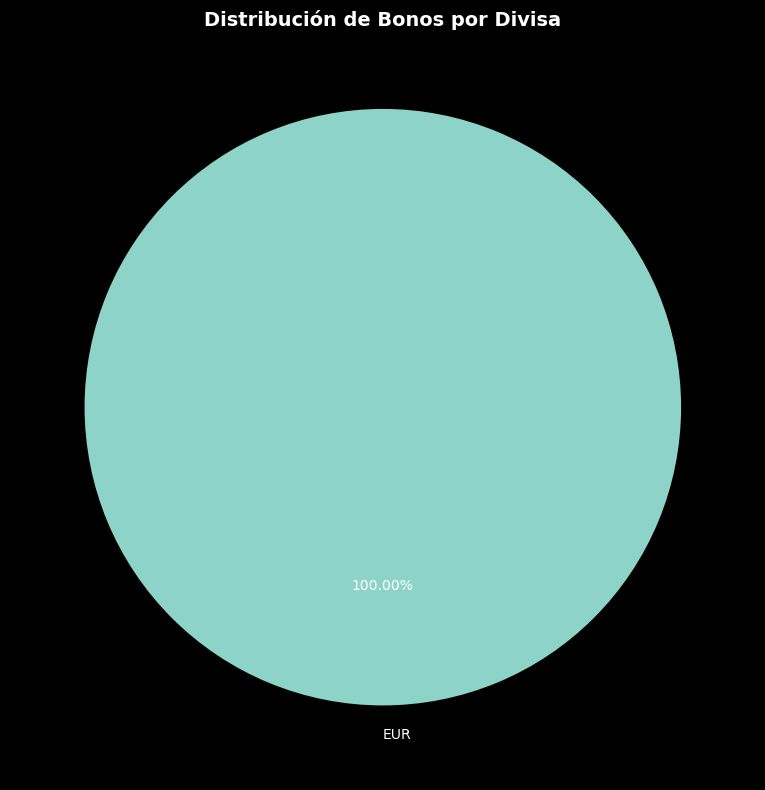

In [6]:

# ANÁLISIS DE DIVISAS:
# Analizamos la distribución de bonos por divisa (moneda)
# Esto es importante porque afecta al riesgo cambiario de la cartera


# Contamos cuántos bonos hay de cada divisa
divisas = universo['Ccy'].value_counts()

print("Distribución de divisas:")
print(divisas)
print(f"\nTotal de divisas diferentes: {len(divisas)}")
print(f"\nPorcentaje por divisa:")
for ccy, count in divisas.items():
    pct = (count / len(universo)) * 100
    print(f"{ccy}: {pct:.2f}%")

# 
# VISUALIZACIÓN DE DIVISAS:
# Creamos un pie chart para visualizar mejor la distribución

# Ajustamos el tamaño a (8, 8) para asegurar que el círculo no se vea ovalado
fig, ax = plt.subplots(figsize=(8, 8))

divisas.plot(
    kind='pie', 
    ax=ax, 
    autopct='%1.2f%%',    # Muestra el porcentaje con 2 decimales
    startangle=90,        # Empieza a rotar desde la parte superior (12 en punto)
    shadow=False,         # (Opcional) Sombra para efecto 3D
    legend=False          # Ocultamos la leyenda si las etiquetas son claras
)

ax.set_ylabel('')  # Eliminamos la etiqueta automática del eje Y que pone pandas
ax.set_title('Distribución de Bonos por Divisa', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Se puede observar claramente como el 100% de los bonos tienen como divisa el Euro.

#### <font color=#808080>Tipos de bono</font>

In [7]:
# ANÁLISIS DE TIPOS DE BONO:
# Analizamos diferentes características de los bonos que afectan a su
# valoración y riesgo: tipo de cupón, prelación, opcionalidad y perpetuos
#


# 1. TIPO DE CUPÓN (FIJO VS VARIABLE):
# Los bonos pueden tener cupón fijo (tasa constante) o variable (tasa flotante)
# Esto afecta a la sensibilidad a cambios en tipos de interés

tipo_cupon = universo['Coupon Type'].value_counts()
print("Distribución por tipo de cupón:")
print(tipo_cupon)
print(f"\nPorcentaje:")
for tipo, count in tipo_cupon.items():
    pct = (count / len(universo)) * 100
    print(f"{tipo}: {pct:.2f}%")


# 2. PRELACIÓN (SENIORITY):
# La prelación determina el orden de pago en caso de quiebra del emisor
# Senior tiene prioridad sobre Subordinated

prelacion = universo['Seniority'].value_counts()
print(f"\n\nDistribución por prelación:")
print(prelacion)
print(f"\nPorcentaje:")
for sen, count in prelacion.items():
    pct = (count / len(universo)) * 100
    print(f"{sen}: {pct:.2f}%")


# 3. OPCIONALIDAD (CALLABLE):
# Los bonos callable pueden ser recomprados por el emisor antes del vencimiento
# Esto introduce riesgo de reinversión para el inversor

callable_bonds = universo['Callable'].value_counts()
print(f"\n\nBonos con opción de compra (Callable):")
print(callable_bonds)
print(f"\nPorcentaje:")
for call, count in callable_bonds.items():
    pct = (count / len(universo)) * 100
    print(f"{call}: {pct:.2f}%")


# 4. BONOS PERPETUOS (SIN FECHA DE VENCIMIENTO):
# Los bonos perpetuos no tienen fecha de vencimiento fija
# Para valoración, usaremos la próxima fecha call como vencimiento

perpetuos = universo[universo['Maturity'].isna()]
print(f"Bonos perpetuos encontrados: {len(perpetuos)}")


Distribución por tipo de cupón:
Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

Porcentaje:
FIXED: 84.70%
VARIABLE: 15.30%


Distribución por prelación:
Seniority
Sr Unsecured        1675
Sr Non Preferred     190
Sr Preferred         179
Subordinated         153
Jr Subordinated       25
Secured               20
1st lien              13
Name: count, dtype: int64

Porcentaje:
Sr Unsecured: 74.28%
Sr Non Preferred: 8.43%
Sr Preferred: 7.94%
Subordinated: 6.78%
Jr Subordinated: 1.11%
Secured: 0.89%
1st lien: 0.58%


Bonos con opción de compra (Callable):
Callable
Y    1640
N     615
Name: count, dtype: int64

Porcentaje:
Y: 72.73%
N: 27.27%
Bonos perpetuos encontrados: 19


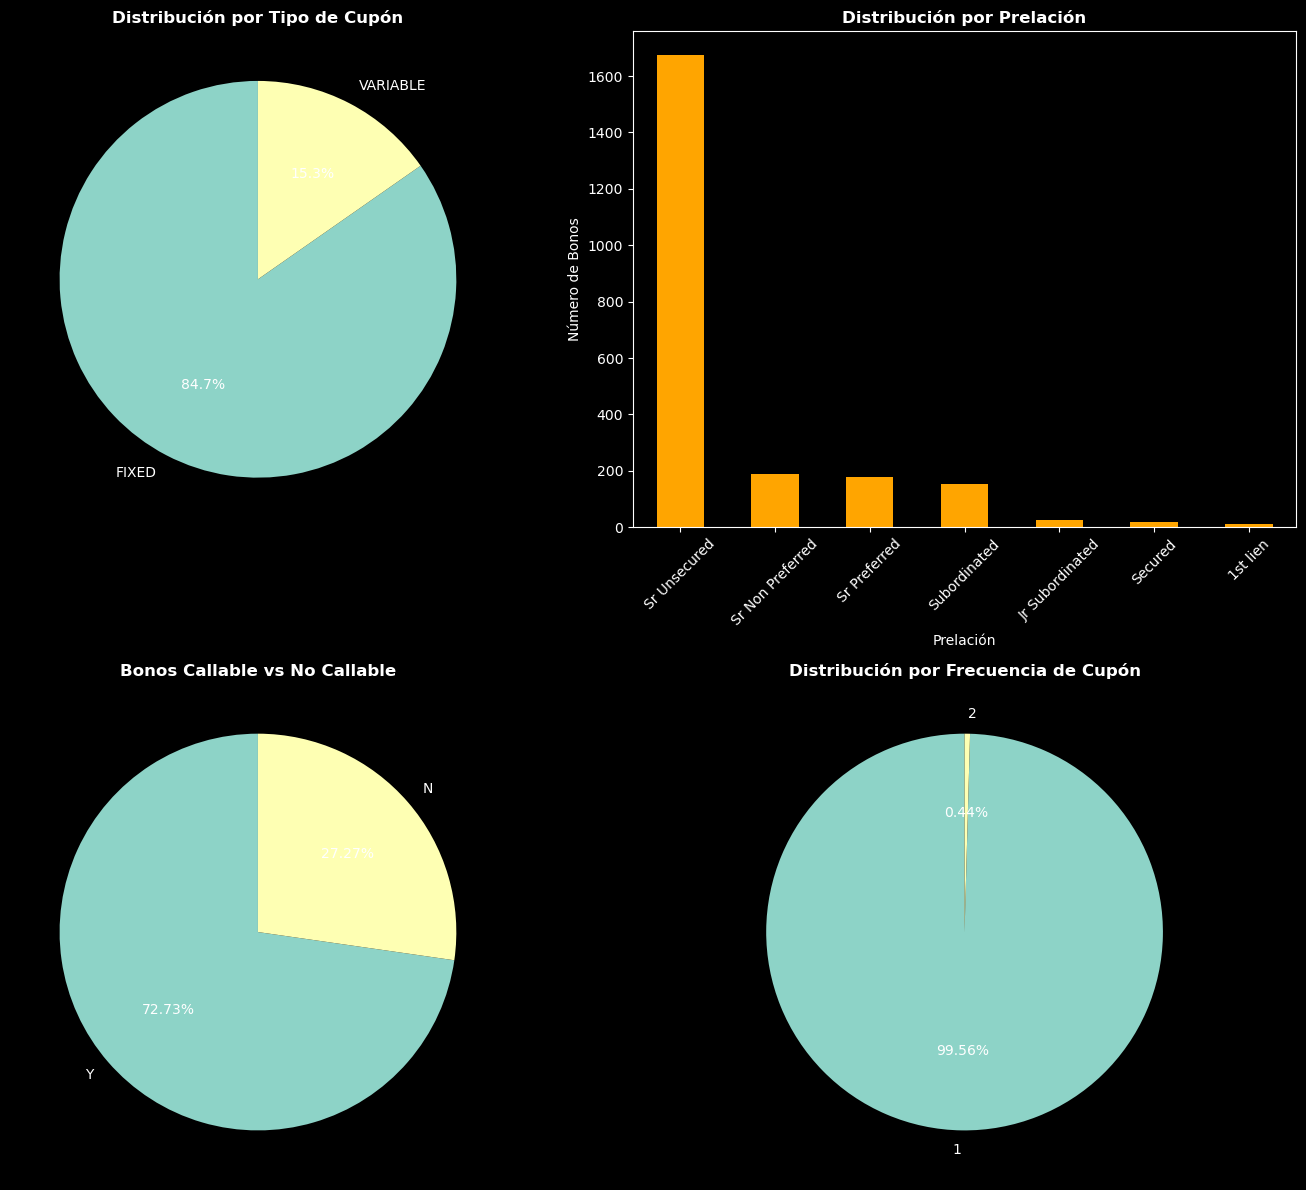

In [8]:
# VISUALIZACIONES DE TIPOS DE BONO:
# Creamos un panel de 4 gráficos para visualizar todas las características
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Gráfico 1: Tipo de cupón ---
tipo_cupon.plot(
    kind='pie', 
    ax=axes[0, 0], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='' # Ocultar etiqueta del eje Y
)
axes[0, 0].set_title('Distribución por Tipo de Cupón', fontsize=12, fontweight='bold')

# --- Gráfico 2: Prelación ---
prelacion.plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribución por Prelación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prelación')
axes[0, 1].set_ylabel('Número de Bonos')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Gráfico 3: Callable ---
callable_bonds.plot(
    kind='pie', 
    ax=axes[1, 0], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel='',
    

)
axes[1, 0].set_title('Bonos Callable vs No Callable', fontsize=12, fontweight='bold')

# --- Gráfico 4: Frecuencia de cupón ---
freq_cupon = universo['Coupon Frequency'].value_counts()
freq_cupon.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel=''
)
axes[1, 1].set_title('Distribución por Frecuencia de Cupón', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


#### <font color=#808080>Sectores y emisores</font>

Distribución por sectores:
Industry Sector
Financial                 1012
Consumer, Non-cyclical     400
Industrial                 211
Communications             175
Consumer, Cyclical         171
Utilities                  150
Basic Materials             72
Technology                  51
Energy                      13
Name: count, dtype: int64

Total de sectores diferentes: 9


Total de emisores diferentes: 613

Top 10 emisores por número de emisiones:
Issuer
BANQUE FED CRED MUTUEL     33
BNP PARIBAS                27
VONOVIA SE                 23
ORANGE SA                  23
BPCE SA                    23
SOCIETE GENERALE           21
VOLKSWAGEN INTL FIN NV     21
NESTLE FINANCE INTL LTD    20
CREDIT AGRICOLE SA         19
UNIBAIL-RODAMCO-WESTFLD    19
Name: count, dtype: int64


Concentración de los top 10 emisores: 10.16%
Concentración del top emisor: 1.46%


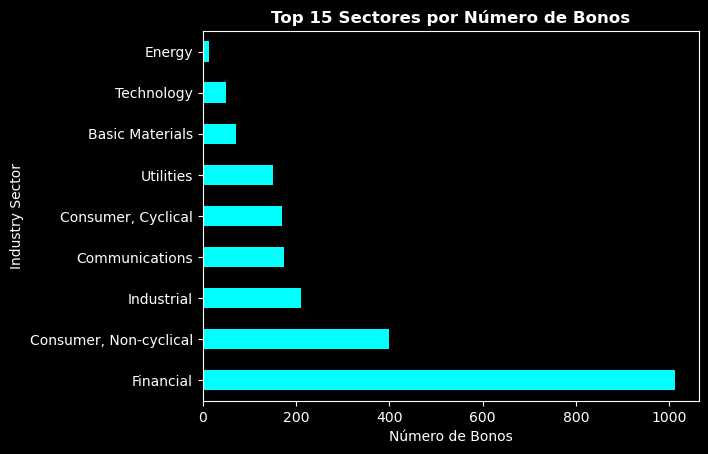

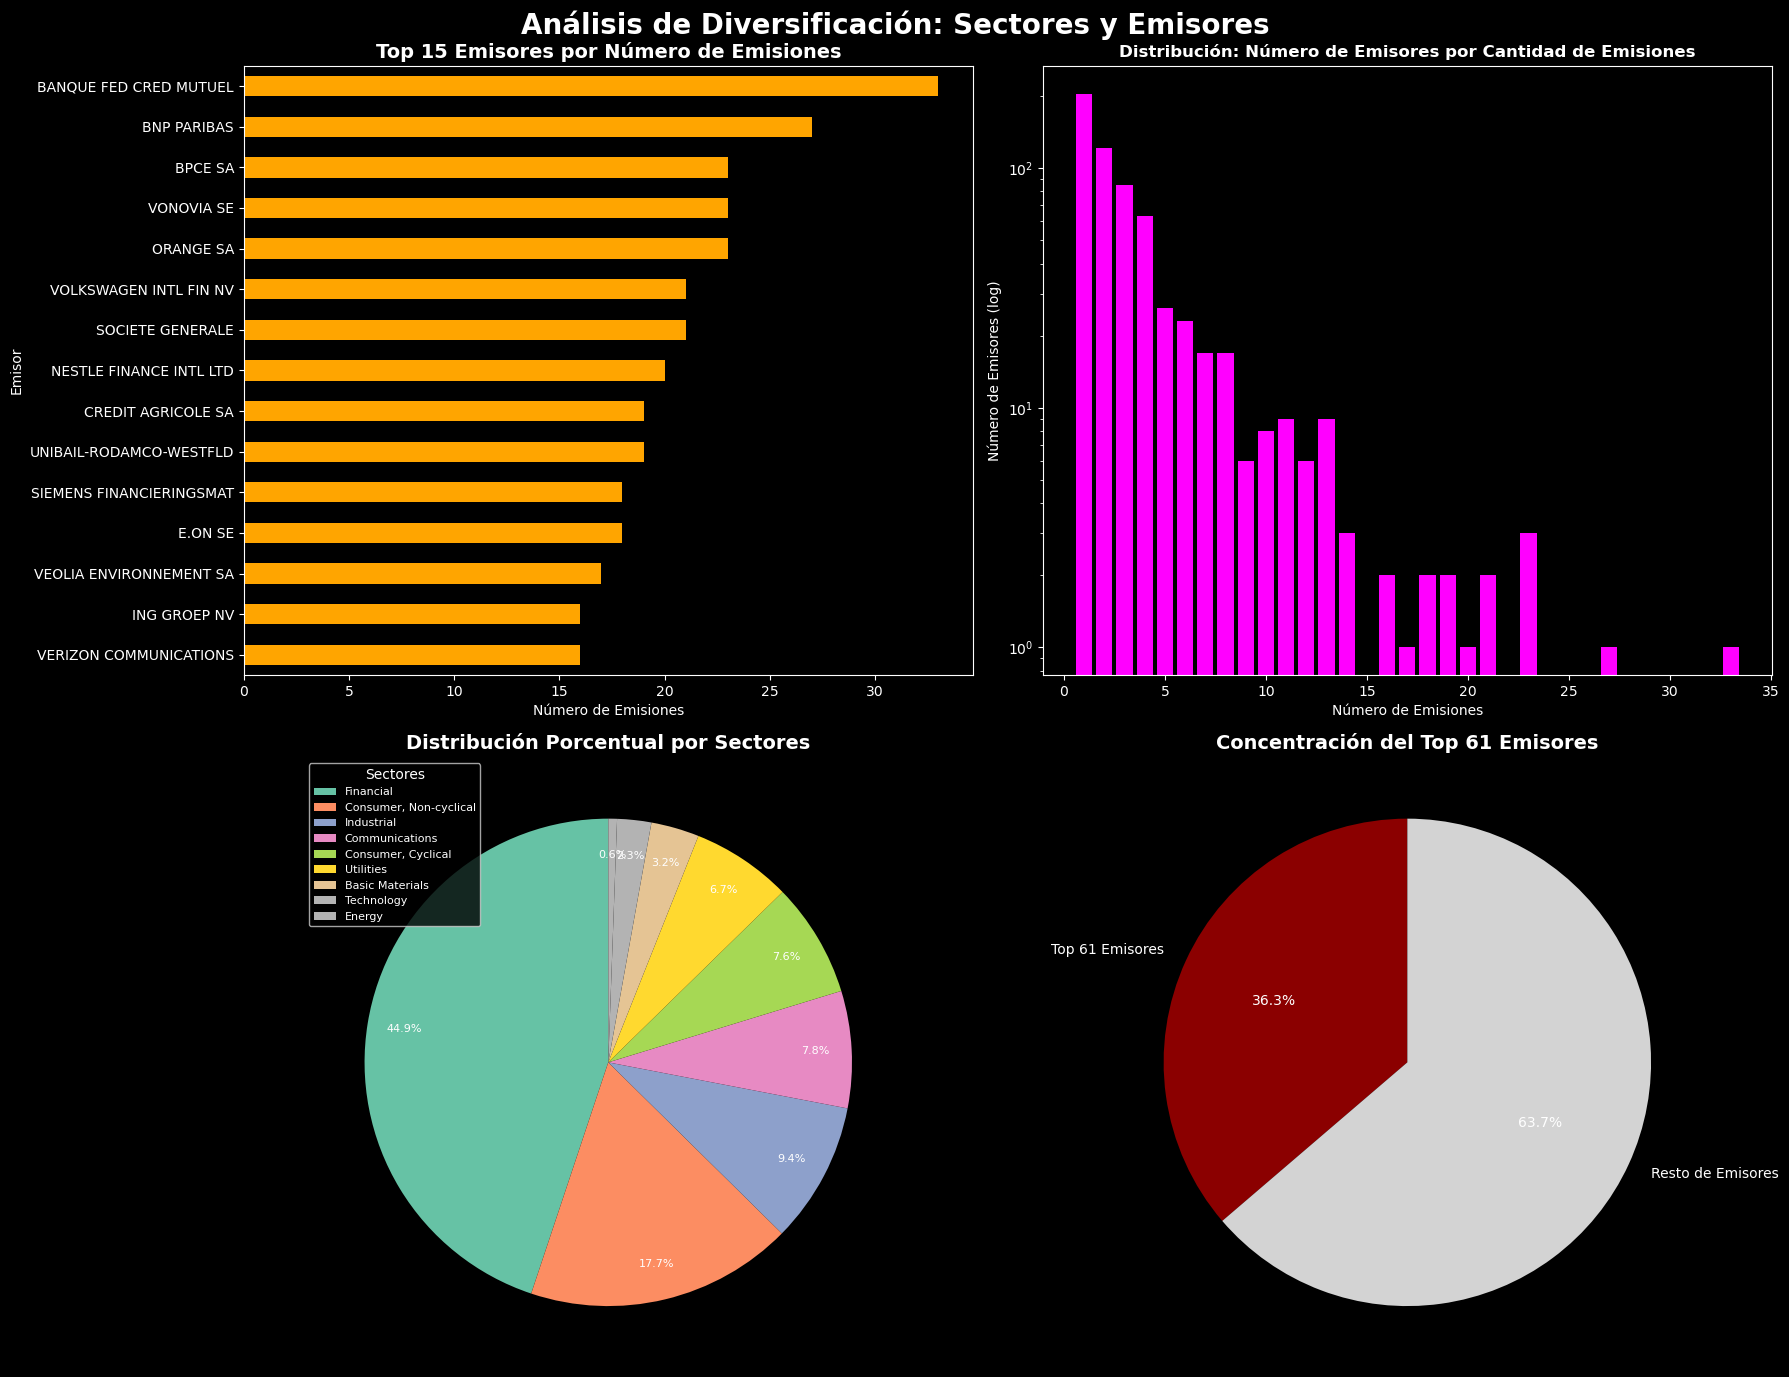


ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA

1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE
• 2,255 bonos = riesgo casi eliminado
• 613 emisores con top 1 solo 1.46% = protección contra defaults
• Top 10 emisores: 10.16% = baja concentración por emisor
• Comparable a índices profesionales (iBoxx ~2,500 bonos)

✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)

2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE
• 44.9% en sector financiero vs ~30% en benchmarks (+14.9pp sobreexpuesto)
• HHI sectorial: 2594 (>2,500 = alta concentración)

 RIESGO SISTÉMICO BANCARIO:
   - Bancos interconectados (se prestan entre sí)

• Sectores defensivos bajos: Energy 0.6%, Tech 2.3%, Utilities 6.7%

 PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)

5. RECOMENDACIONES
• Limitar financiero a ≤30%
• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%

CONCLUSIÓN GENERAL:
EXCELENTE diversificación horizontal (bono

In [9]:
# ANÁLISIS DE SECTORES Y EMISORES:
# Analizamos la diversificación de la cartera por sector industrial y emisor
# Una cartera bien diversificada reduce el riesgo de concentración


# 1. DISTRIBUCIÓN POR SECTORES:
# Contamos cuántos bonos hay en cada sector industrial

sectores = universo['Industry Sector'].value_counts()
print("Distribución por sectores:")
print(sectores)
print(f"\nTotal de sectores diferentes: {len(sectores)}")


# 2. DISTRIBUCIÓN POR EMISORES:
# Contamos cuántas emisiones tiene cada emisor
# Esto nos ayuda a identificar concentración por emisor


emisores = universo['Issuer'].value_counts()
print(f"\n\nTotal de emisores diferentes: {len(emisores)}")
print(f"\nTop 10 emisores por número de emisiones:")
print(emisores.head(10))


# 3. ANÁLISIS DE CONCENTRACIÓN:
# Calculamos la concentración de la cartera si fuera equiponderada
# Una alta concentración aumenta el riesgo de la cartera


peso_por_emisor = emisores / len(universo) * 100
concentracion_top10 = peso_por_emisor.head(10).sum()
print(f"\n\nConcentración de los top 10 emisores: {concentracion_top10:.2f}%")
print(f"Concentración del top emisor: {peso_por_emisor.iloc[0]:.2f}%")

# ============================================================================
# VISUALIZACIONES DE SECTORES Y EMISORES
# ============================================================================
# Creamos un panel de 4 gráficos para analizar la diversificación
# ============================================================================


fig= figsize=(16, 12)
# Sectores - Top 15
sectores.head(15).plot(kind='barh', color='cyan')
plt.title('Top 15 Sectores por Número de Bonos', fontsize=12, fontweight='bold')
plt.xlabel('Número de Bonos')


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.suptitle('Análisis de Diversificación: Sectores y Emisores', fontsize=20, fontweight='bold')

# --- 1. Top 15 Emisores (Mantenido - Barras Horizontales) ---
emisores.head(15).sort_values(ascending=True).plot(
    kind='barh', 
    ax=axes[0, 0], 
    color='orange'
)
axes[0, 0].set_title('Top 15 Emisores por Número de Emisiones', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Emisiones')
axes[0, 0].set_ylabel('Emisor')


# Distribución de número de emisiones por emisor
num_emisiones_por_emisor = emisores.value_counts().sort_index()
axes[0, 1].bar(num_emisiones_por_emisor.index, num_emisiones_por_emisor.values, color='magenta')
axes[0, 1].set_title('Distribución: Número de Emisores por Cantidad de Emisiones', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Número de Emisiones')
axes[0, 1].set_ylabel('Número de Emisores (log)')
axes[0, 1].set_yscale('log')

# --- 3. Distribución Porcentual por Sectores (NUEVO - Gráfico Circular) ---
# Ajustamos el gráfico para evitar solapamiento de etiquetas
wedges, texts, autotexts = axes[1, 0].pie(
    sectores.values,
    labels=None,  # No mostramos etiquetas en el gráfico para evitar solapamiento
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set2(range(len(sectores))),
    pctdistance=0.85,
    textprops={'fontsize': 8}
)

# Añadimos leyenda fuera del gráfico para evitar solapamiento
axes[1, 0].legend(
    wedges, 
    sectores.index, 
    title="Sectores",
    loc="best",
    fontsize=8,
    frameon=True
)
axes[1, 0].set_title('Distribución Porcentual por Sectores', fontsize=14, fontweight='bold')


# --- 4. Concentración del Top 10% Emisores (NUEVO - Gráfico Circular) ---
# 3. Concentración para el Gráfico Circular
# Calcular el 10% del total de emisores
total_emisores = len(emisores)
num_emisores_top10pct = max(1, round(total_emisores * 0.10))

# Sumar las emisiones del Top 10% de emisores
top_emisores_count = emisores.head(num_emisores_top10pct).sum()
rest_emisores_count = len(universo) - top_emisores_count

# Crear la serie para el gráfico circular de concentración
concentracion_data = pd.Series(
    [top_emisores_count, rest_emisores_count], 
    index=[f'Top {num_emisores_top10pct} Emisores', 'Resto de Emisores']
)
concentracion_data.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='', 
    colors=['darkred', 'lightgray']
)
axes[1, 1].set_title(f'Concentración del Top {num_emisores_top10pct} Emisores', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS DE DIVERSIFICACIÓN HORIZONTAL VS VERTICAL
# ============================================================================
# Calculamos HHI sectorial y porcentajes de distribución
# ============================================================================

# Cálculo de HHI (Herfindahl-Hirschman Index) sectorial
peso_sectorial = sectores / len(universo) * 100
hhi_sectorial = (peso_sectorial ** 2).sum()

# Distribución porcentual por sector
distribucion_sectorial = peso_sectorial.sort_values(ascending=False)
pct_financiero = distribucion_sectorial.get('Financial', 0)
pct_consumer_nc = distribucion_sectorial.get('Consumer, Non-cyclical', 0)
pct_industrial = distribucion_sectorial.get('Industrial', 0)
pct_energy = distribucion_sectorial.get('Energy', 0)
pct_tech = distribucion_sectorial.get('Technology', 0)
pct_utilities = distribucion_sectorial.get('Utilities', 0)

# ============================================================================
# CONCLUSIÓN SOBRE DIVERSIFICACIÓN
# ============================================================================
# Análisis completo de diversificación horizontal (bonos/emisores) 
# vs vertical (sectores)
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE")
print(f"{'='*80}")
print(f"• 2,255 bonos = riesgo casi eliminado")
print(f"• 613 emisores con top 1 solo {peso_por_emisor.iloc[0]:.2f}% = protección contra defaults")
print(f"• Top 10 emisores: {concentracion_top10:.2f}% = baja concentración por emisor")
print(f"• Comparable a índices profesionales (iBoxx ~2,500 bonos)")
print(f"\n✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)")

print(f"\n{'='*80}")
print("2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE")
print(f"{'='*80}")
print(f"• {pct_financiero:.1f}% en sector financiero vs ~30% en benchmarks (+{pct_financiero-30:.1f}pp sobreexpuesto)")
print(f"• HHI sectorial: {hhi_sectorial:.0f} (>2,500 = alta concentración)")
print(f"\n RIESGO SISTÉMICO BANCARIO:")
print(f"   - Bancos interconectados (se prestan entre sí)")
print(f"\n• Sectores defensivos bajos: Energy {pct_energy:.1f}%, Tech {pct_tech:.1f}%, Utilities {pct_utilities:.1f}%")
print(f"\n PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)")

print(f"\n{'='*80}")
print("5. RECOMENDACIONES")
print(f"{'='*80}")
print("• Limitar financiero a ≤30%")
print("• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%")

print(f"\n{'='*80}")
print("CONCLUSIÓN GENERAL:")
print(f"{'='*80}")
print("EXCELENTE diversificación horizontal (bonos/emisores) pero")
print("PREOCUPANTE diversificación vertical (sectores) por alta")
print(f"concentración en financiero ({pct_financiero:.1f}%) y su riesgo sistémico")
print(f"{'='*80}")


Se observa que el 44,9% de los bonos tienen como emisor empresas del sector financiero. Provocando una gran dependencia de este sector y un riesgo sistémico. También cabe notar que hay una cierta diversificación entre los emsisores más numerosos ya que los diez emisores con mas bonos tienen el 10% de la cartera. Al mismo tiempo el top 10% de emisores solo abarca el 36% de los bonos de la cartera.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

Distribución de ratings:
Rating
A       230
A+      185
A-      374
AA       22
AA+       7
AA-     100
AAA       4
BB+      10
BBB     310
BBB+    439
BBB-    184
NR      389
Name: count, dtype: int64

Total de ratings diferentes: 12

Porcentaje por rating:
A: 10.20%
A+: 8.20%
A-: 16.59%
AA: 0.98%
AA+: 0.31%
AA-: 4.43%
AAA: 0.18%
BB+: 0.44%
BBB: 13.75%
BBB+: 19.47%
BBB-: 8.16%
NR: 17.25%


Clasificación por categoría de riesgo:
Rating_Class
Investment Grade    1855
No Rating            390
High Yield            10
Name: count, dtype: int64

Porcentaje:
Investment Grade: 82.26%
No Rating: 17.29%
High Yield: 0.44%


Análisis de Probabilidad de Default (PD 1YR):
Valores nulos: 24
Estadísticas descriptivas:
count    2.231000e+03
mean     3.616280e-03
std      8.372564e-03
min      2.944640e-12
25%      1.502910e-05
50%      1.253650e-04
75%      1.270443e-03
max      6.312192e-02
Name: PD 1YR, dtype: float64


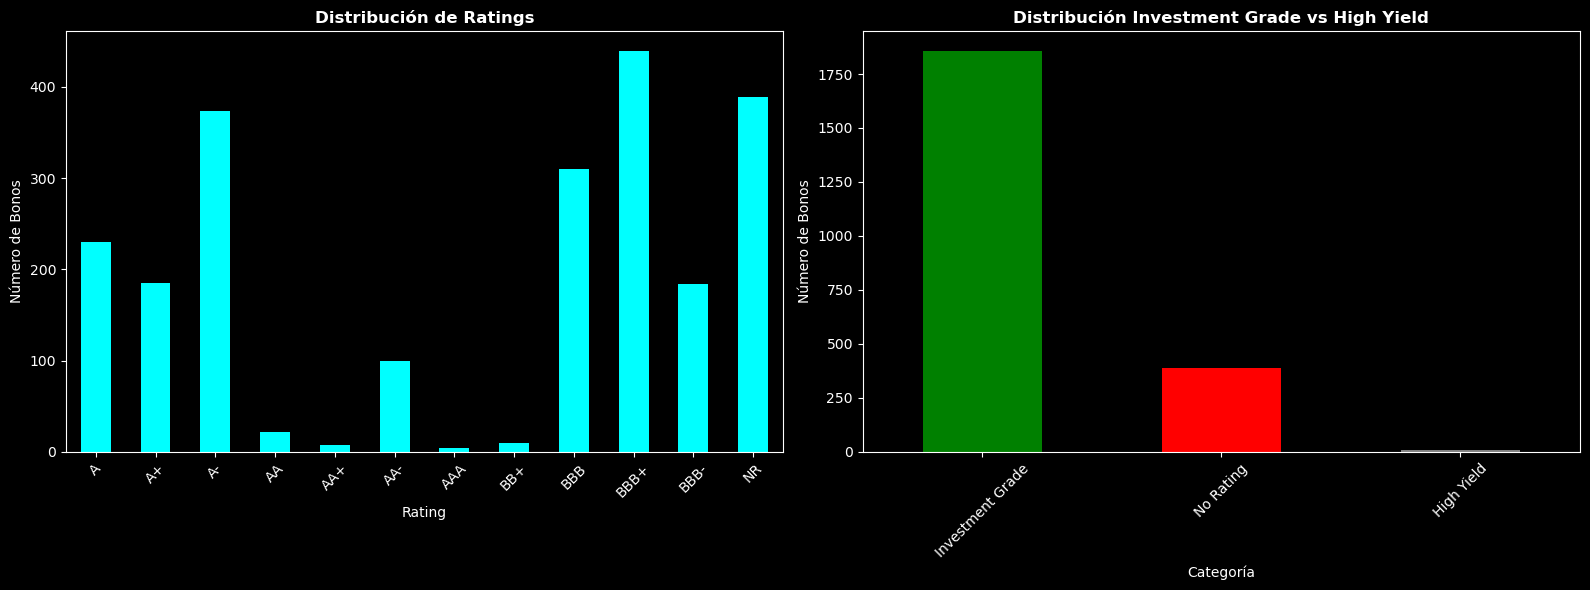

In [10]:
# ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO):
# El rating es una medida clave del riesgo crediticio de cada bono
# Analizamos la distribución de ratings y los clasificamos en categorías

# DISTRIBUCIÓN DE RATINGS:
# Contamos cuántos bonos hay de cada rating específico

ratings = universo['Rating'].value_counts().sort_index()
print("Distribución de ratings:")
print(ratings)
print(f"\nTotal de ratings diferentes: {len(ratings)}")
print(f"\nPorcentaje por rating:")
for rating, count in ratings.items():
    pct = (count / len(universo)) * 100
    print(f"{rating}: {pct:.2f}%")

# CLASIFICACIÓN INVESTMENT GRADE VS HIGH YIELD:
# Definimos las categorías de ratings:
# - Investment Grade: AAA hasta BBB- (menor riesgo crediticio)
# - High Yield: BB+ hasta D (mayor riesgo crediticio)

investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']


# FUNCIÓN PARA CLASIFICAR RATINGS:
# Esta función clasifica cada rating en Investment Grade, High Yield o No Rating

def clasificar_rating(rating):
    if pd.isna(rating) or rating == '' or rating == 'NR':
        return 'No Rating'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'Investment Grade'
    elif rating_clean in high_yield:
        return 'High Yield'
    else:
        return 'No Rating'

# Aplicamos la clasificación a todos los bonos
universo['Rating_Class'] = universo['Rating'].apply(clasificar_rating)
rating_class = universo['Rating_Class'].value_counts()

print(f"\n\nClasificación por categoría de riesgo:")
print(rating_class)
print(f"\nPorcentaje:")
for clase, count in rating_class.items():
    pct = (count / len(universo)) * 100
    print(f"{clase}: {pct:.2f}%")

# ANÁLISIS DE PD (PROBABILIDAD DE DEFAULT A 1 AÑO):
# La PD es una medida cuantitativa del riesgo de impago
# Valores más altos indican mayor probabilidad de default

print(f"\n\nAnálisis de Probabilidad de Default (PD 1YR):")
print(f"Valores nulos: {universo['PD 1YR'].isna().sum()}")
print(f"Estadísticas descriptivas:")
print(universo['PD 1YR'].describe())

# ============================================================================
# VISUALIZACIONES DE RATINGS Y RIESGO DE CRÉDITO
# ============================================================================
# Creamos un panel de 4 gráficos para analizar el riesgo crediticio
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # figsize ajustado para mejor aspecto horizontal

# Distribución de ratings
# Indexación corregida: axes[0]
ratings.plot(kind='bar', ax=axes[0], color='cyan')
axes[0].set_title('Distribución de Ratings', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Número de Bonos')
axes[0].tick_params(axis='x', rotation=45)

# Clasificación IG vs HY
# Indexación corregida: axes[1]
rating_class.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Distribución Investment Grade vs High Yield', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Número de Bonos')
axes[1].tick_params(axis='x', rotation=45)

# Ajusta automáticamente el espaciado para que los elementos no se superpongan
plt.tight_layout()

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

Análisis de Horquillas (Bid-Ask Spread):
Valores nulos en Bid Price: 0
Valores nulos en Ask Price: 0

Estadísticas del spread absoluto:
count    2255.000000
mean        0.327213
std         0.165488
min         0.064000
25%         0.201000
50%         0.294000
75%         0.418000
max         2.255000
Name: Bid_Ask_Spread, dtype: float64

Estadísticas del spread porcentual:
count    2255.000000
mean        0.346703
std         0.198603
min         0.065484
25%         0.203803
50%         0.301650
75%         0.433251
max         2.521074
Name: Bid_Ask_Spread_Pct, dtype: float64


Análisis de Nominal Vivo (Outstanding Amount):
Valores nulos: 0
Estadísticas descriptivas (en millones):
count    2255.000000
mean      744.928859
std       309.513822
min       249.997000
25%       500.000000
50%       700.000000
75%      1000.000000
max      3000.000000
Name: Outstanding Amount, dtype: float64


Distribución por tamaño de emisión:
Tamaño_Emision
500M - 1B    1549
1B - 2B       556
< 500M  

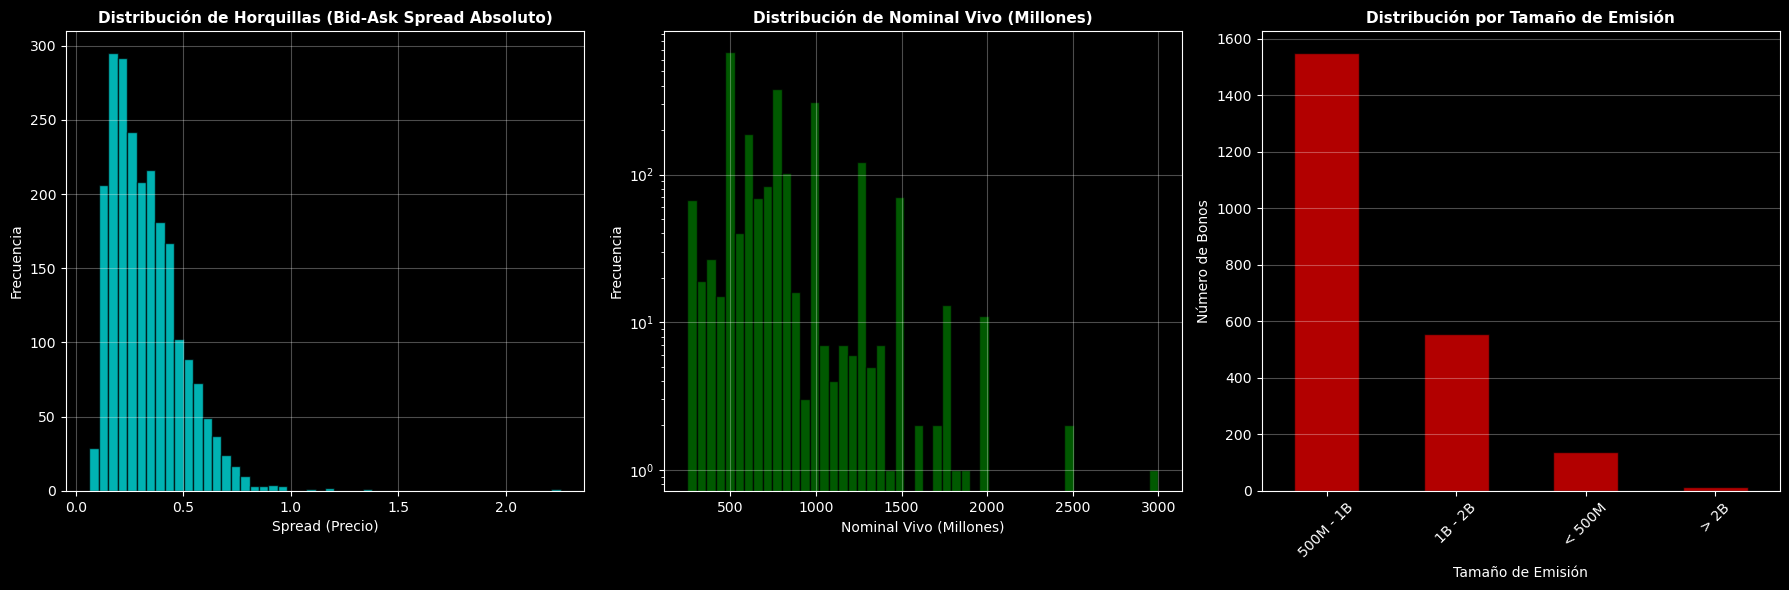


CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:
- Horquilla media: 0.347%
- Horquilla mediana: 0.302%
- Bonos con horquilla > 1%: 27 (1.20%)
- Bonos con emisión < 500M: 136 (6.03%)
- Bonos con emisión >= 500M: 2119 (93.97%)


In [11]:
# ============================================================================
# ANÁLISIS DE RIESGO DE LIQUIDEZ - HORQUILLAS Y NOMINAL VIVO
# ============================================================================
# El riesgo de liquidez mide la facilidad para comprar/vender un bono
# Analizamos horquillas bid-ask y tamaño de emisión (nominal vivo)
# ============================================================================

# ============================================================================
# 1. CÁLCULO DE HORQUILLAS (BID-ASK SPREAD)
# ============================================================================
# La horquilla es la diferencia entre precio de compra (Ask) y venta (Bid)
# Horquillas más amplias indican menor liquidez
# ============================================================================

universo['Bid_Ask_Spread'] = universo['Ask Price'] - universo['Bid Price']
universo['Bid_Ask_Spread_Pct'] = (universo['Bid_Ask_Spread'] / universo['Price']) * 100

print("Análisis de Horquillas (Bid-Ask Spread):")
print(f"Valores nulos en Bid Price: {universo['Bid Price'].isna().sum()}")
print(f"Valores nulos en Ask Price: {universo['Ask Price'].isna().sum()}")
print(f"\nEstadísticas del spread absoluto:")
print(universo['Bid_Ask_Spread'].describe())
print(f"\nEstadísticas del spread porcentual:")
print(universo['Bid_Ask_Spread_Pct'].describe())

# ============================================================================
# EXPLICACIÓN DE LECTURA DE LAS ESTADÍSTICAS DE SPREAD
# ============================================================================
# 
# SPREAD ABSOLUTO (Bid_Ask_Spread):
# - Representa la diferencia en unidades monetarias (€) entre el precio 
#   de compra (Ask) y el precio de venta (Bid)
# - Ejemplo: Si Ask = 100.50€ y Bid = 100.30€, el spread absoluto = 0.20€
# - Interpretación:
#   * Spread bajo (< 0.30€): Alta liquidez, fácil comprar/vender
#   * Spread medio (0.30-0.50€): Liquidez moderada
#   * Spread alto (> 0.50€): Baja liquidez, mayor coste de transacción
#
# SPREAD PORCENTUAL (Bid_Ask_Spread_Pct):
# - Representa el spread absoluto como porcentaje del precio del bono
# - Fórmula: (Spread Absoluto / Precio del Bono) × 100
# - Ejemplo: Si spread absoluto = 0.20€ y precio = 100€, spread % = 0.20%
# - Interpretación:
#   * Spread < 0.25%: Excelente liquidez (bonos muy líquidos)
#   * Spread 0.25-0.50%: Buena liquidez (bonos estándar)
#   * Spread 0.50-1.00%: Liquidez moderada (riesgo de liquidez medio)
#   * Spread > 1.00%: Baja liquidez (riesgo elevado, difícil salir)
#
# ESTADÍSTICAS DESCRIPTIVAS:
# - count: Número de bonos con datos disponibles
# - mean: Promedio de todos los spreads (tendencia central)
# - std: Desviación estándar (variabilidad: mayor = más dispersión)
# - min/25%/50%/75%/max: Percentiles (25%=Q1, 50%=mediana, 75%=Q3)
#   * Mediana (50%): Valor central, resiste a valores extremos
#   * Q3 (75%): 75% de los bonos tienen spread menor o igual
#
# RELACIÓN SPREAD ABSOLUTO vs PORCENTUAL:
# - El spread absoluto es más útil para comparar bonos con precios similares
# - El spread porcentual permite comparar bonos con diferentes precios
# - Un bono con precio alto puede tener spread absoluto alto pero % bajo
#   (ej: precio 150€, spread 0.45€ = 0.30% → aún buena liquidez)
#
# ============================================================================

# ============================================================================
# 2. ANÁLISIS DE NOMINAL VIVO (OUTSTANDING AMOUNT)
# ============================================================================
# El nominal vivo es el tamaño total de la emisión en circulación
# Emisiones más grandes suelen tener mayor liquidez
# ============================================================================

print(f"\n\nAnálisis de Nominal Vivo (Outstanding Amount):")
print(f"Valores nulos: {universo['Outstanding Amount'].isna().sum()}")
print(f"Estadísticas descriptivas (en millones):")
outstanding_millions = universo['Outstanding Amount'] / 1_000_000
print(outstanding_millions.describe())

# ============================================================================
# CLASIFICACIÓN POR TAMAÑO DE EMISIÓN
# ============================================================================
# Clasificamos las emisiones en categorías según su tamaño
# Esto nos ayuda a identificar bonos con mayor o menor liquidez potencial
# ============================================================================

def clasificar_tamano(nominal):
    if pd.isna(nominal):
        return 'Sin dato'
    nominal_mill = nominal / 1_000_000
    if nominal_mill < 500:
        return '< 500M'
    elif nominal_mill < 1000:
        return '500M - 1B'
    elif nominal_mill < 2000:
        return '1B - 2B'
    else:
        return '> 2B'

universo['Tamaño_Emision'] = universo['Outstanding Amount'].apply(clasificar_tamano)
tamano_dist = universo['Tamaño_Emision'].value_counts()
print(f"\n\nDistribución por tamaño de emisión:")
print(tamano_dist)

# ============================================================================
# RELACIÓN ENTRE HORQUILLA Y TAMAÑO DE EMISIÓN
# ============================================================================
# Analizamos la correlación: emisiones más grandes suelen tener menor horquilla
# ============================================================================

print(f"\n\nCorrelación entre horquilla y tamaño de emisión:")
correlacion = universo[['Bid_Ask_Spread_Pct', 'Outstanding Amount']].corr()
print(correlacion)

# ============================================================================
# VISUALIZACIONES DE RIESGO DE LIQUIDEZ
# ============================================================================
# Creamos un panel de 6 gráficos para analizar la liquidez desde diferentes
# perspectivas
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma de horquillas absolutas
spread_data = universo['Bid_Ask_Spread'].dropna()
axes[0].hist(spread_data, bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Horquillas (Bid-Ask Spread Absoluto)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Spread (Precio)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)


# Distribución de nominal vivo
outstanding_data = outstanding_millions.dropna()
axes[1].hist(outstanding_data, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Nominal Vivo (Millones)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Nominal Vivo (Millones)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# 3. Distribución por tamaño de emisión (CORRECCIÓN AQUÍ)
# Cambiado axes[1, 2] por axes[2]
tamano_dist.plot(kind='bar', ax=axes[2], color='red', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribución por Tamaño de Emisión', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Tamaño de Emisión')
axes[2].set_ylabel('Número de Bonos')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ
# ============================================================================
# Resumen de los principales indicadores de liquidez
# ============================================================================

print(f"\n{'='*60}")
print("CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:")
print(f"{'='*60}")
print(f"- Horquilla media: {universo['Bid_Ask_Spread_Pct'].mean():.3f}%")
print(f"- Horquilla mediana: {universo['Bid_Ask_Spread_Pct'].median():.3f}%")
print(f"- Bonos con horquilla > 1%: {(universo['Bid_Ask_Spread_Pct'] > 1).sum()} ({(universo['Bid_Ask_Spread_Pct'] > 1).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión < 500M: {(outstanding_millions < 500).sum()} ({(outstanding_millions < 500).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión >= 500M: {(outstanding_millions >= 500).sum()} ({(outstanding_millions >= 500).sum()/len(universo)*100:.2f}%)")


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [12]:
# El archivo está en '../data/precios_historicos_universo.csv'
file_path = '../data/precios_historicos_universo.csv'

print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: ")

# 1. CARGA DE DATOS
# Cargamos el archivo. El índice 0 (la primera columna) contiene los ISINs.
# La primera celda del encabezado está vacía, por lo que es mejor renombrar la columna 0.
precios_universo = pd.read_csv(
    file_path, 
    sep=';', 
    decimal='.', 
    na_values=['#N/D', ' ', 'NA', 'nan', 'N/A', '']
)
reportar_gaps_informacion(precios_universo, "Precios Históricos Universo")
# 2. PREPARACIÓN Y TRANSPOSICIÓN
# Renombramos la primera columna a 'ISIN' y la establecemos como el índice.
precios_df_preparado = precios_universo.rename(
    columns={precios_universo.columns[0]: 'Date'}
).set_index('Date')

# Ejecutamos la Transpuesta (.T)
precios_transpuesto = precios_df_preparado.T


# 3. LIMPIEZA DE FECHAS
# Convertir el nuevo índice (las fechas) a tipo datetime.
precios_transpuesto.index = pd.to_datetime(
    precios_transpuesto.index, 
    format='%d/%m/%Y', 
    errors='coerce' 
)
# 4. Eliminamos la primera fila al ser todos valores nulos y los nulos usamos forward fill
precios_transpuesto = precios_transpuesto.dropna(how='all').ffill(axis=1)


# 5. Mostrar el resultado
print("\n--- Vista Previa del DataFrame Traspuesto ---")
display(precios_transpuesto)


ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: 

 ANÁLISIS DE VALORES NULOS: Precios Históricos Universo
Total de filas: 2255
Columnas con datos faltantes: 299
------------------------------------------------------------
           Tipo de Dato  Cantidad Nulos  Porcentaje (%)
28/09/2025      float64            2255          100.00
01/10/2023      float64            2255          100.00
27/09/2025      float64            2255          100.00
21/09/2025      float64            2255          100.00
20/09/2025      float64            2255          100.00
...                 ...             ...             ...
28/12/2023      float64               1            0.04
24/04/2025      float64               1            0.04
25/04/2025      float64               1            0.04
15/04/2025      float64               1            0.04
02/05/2025      float64               1            0.04

[299 rows x 3 columns]

--- Vista Previa del DataFrame Traspuesto ---


Date,XS0161488498 Corp,FR0000471930 Corp,XS0162513211 Corp,XS0162869076 Corp,FR0010014845 Corp,FR0010033381 Corp,XS0229567440 Corp,XS0300113254 Corp,XS0350890470 Corp,XS0553728709 Corp,...,XS2726335099 Corp,FR001400MDV4 Corp,XS2728560959 Corp,XS2728561098 Corp,XS2729836234 Corp,XS2724401588 Corp,XS2731506841 Corp,FR001400MLN4 Corp,XS2732952838 Corp,XS2694995163 Corp
2023-10-02,126.4500,130.3860,110.900,112.493,108.2910,116.1970,97.2570,103.831,113.487,103.7880,...,100.2330,100.2330,100.2330,100.2330,100.233,100.233,100.233,100.2330,100.233,100.2330
2023-10-03,126.0000,129.6970,110.567,112.127,107.6080,115.8310,96.5480,103.716,112.907,103.4900,...,100.0870,100.0870,100.0870,100.0870,100.087,100.087,100.087,100.0870,100.087,100.0870
2023-10-04,125.9390,129.4480,110.719,111.844,108.0470,115.9490,96.5480,103.749,113.374,103.0240,...,100.2000,100.2000,100.2000,100.2000,100.200,100.200,100.200,100.2000,100.200,100.2000
2023-10-05,126.3300,129.7950,111.117,112.191,108.4800,116.3050,97.2010,103.907,113.929,103.2730,...,100.3390,100.3390,100.3390,100.3390,100.339,100.339,100.339,100.3390,100.339,100.3390
2023-10-06,126.1170,129.5540,111.036,112.051,108.2770,116.1730,97.1710,103.919,113.891,103.1610,...,99.0740,99.0740,99.0740,99.0740,99.074,99.074,99.074,99.0740,99.074,99.0740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25,127.4310,130.8840,115.351,115.902,111.9080,119.2500,104.9090,104.060,123.983,108.5030,...,101.0950,105.9280,104.1230,103.7050,104.128,107.688,102.859,104.0240,102.175,102.7950
2025-09-26,127.6710,131.0490,115.569,116.124,111.9030,119.4360,105.0980,104.087,124.257,108.5645,...,101.3640,106.0490,104.3260,103.8040,104.181,107.673,103.026,104.0980,102.259,102.8150
2025-09-29,127.7280,131.2600,115.744,116.312,112.2020,119.5824,105.2860,104.104,124.735,108.6110,...,101.7200,106.2170,104.5150,103.8790,104.266,107.684,103.170,104.2118,102.295,102.8595
2025-09-30,127.7160,131.2410,115.723,116.279,112.2766,119.6290,105.3005,104.106,124.696,108.5808,...,101.6980,106.1900,104.4520,103.8940,104.225,107.788,103.188,104.3362,102.291,102.8864


Para una mayor facilidad a la hora de trabajar con los datos los hemos traspuesto creando la primera columna 'Date' que  contiene las fechas y luego para cada ISIN los precios a cada una de las fechas, si hay un valor nulo, lo hemos rellenado con el de la fecha anterior.

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

ANÁLISIS DE OTROS PRECIOS: 

Forma del DataFrame: (514, 7)

 ANÁLISIS DE VALORES NULOS: Precios Varios
Total de filas: 514
Columnas con datos faltantes: 5
------------------------------------------------------------
                            Tipo de Dato  Cantidad Nulos  Porcentaje (%)
ITRX EUR CDSI GEN 5Y Corp        float64               8            1.56
ITRX XOVER CDSI GEN 5Y Corp      float64               8            1.56
DU1 Comdty                       float64               5            0.97
OE1 Comdty                       float64               5            0.97
RX1 Comdty                       float64               5            0.97

 ANÁLISIS DE VALORES NULOS: Precios Varios Limpios
 No se encontraron valores nulos en 'Precios Varios Limpios'.

Rango de fechas: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
Número de fechas: 514

Instrumentos disponibles:
  - Unnamed: 0
  - ITRX EUR CDSI GEN 5Y Corp
  - ITRX XOVER CDSI GEN 5Y Corp
  - DU1 Comdty
  - OE1 Comdty
  - RX1 Comdty
 

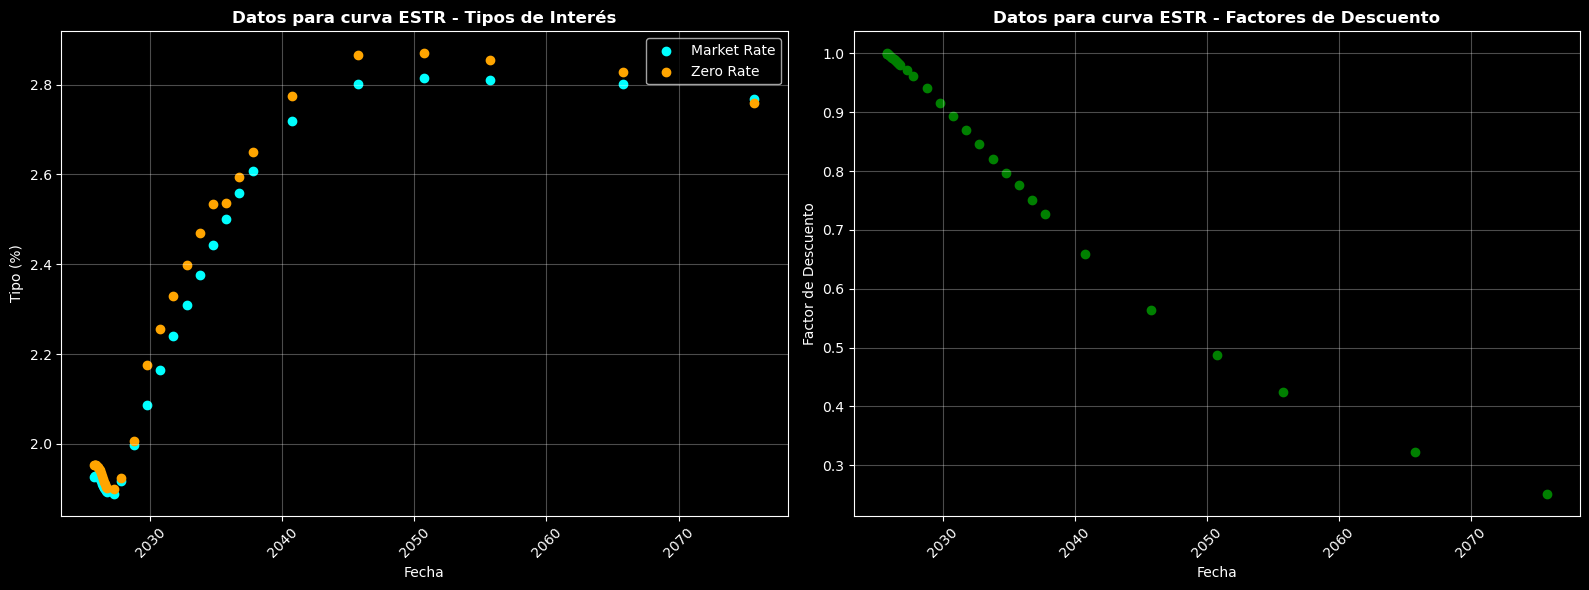

<Figure size 640x480 with 0 Axes>

In [13]:
# Cargar otros precios (futuros, índices de crédito, benchmark)
print("ANÁLISIS DE OTROS PRECIOS: ")
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', sep=';', decimal='.',na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {precios_varios.shape}")
reportar_gaps_informacion(precios_varios, "Precios Varios")


# Convertir la primera columna (fecha) a datetime
fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], format='%d/%m/%Y', errors='coerce')

# Establecer el índice (fecha)
# Es importante hacer esto ANTES del ffill para asegurar la estructura temporal
precios_varios_indexed = precios_varios.set_index(fecha_col)

# Ordenar por fecha
# CRUCIAL: Si los datos no están ordenados cronológicamente, el ffill rellenará datos futuros con pasados o viceversa erróneamente.
precios_varios_indexed.sort_index(inplace=True)

# Limpieza (Forward Fill)
# Usamos ffill() para arrastrar el último precio conocido hacia adelante en los huecos
precios_varios_limpios = precios_varios_indexed.ffill()

# (Opcional) Si al principio de la serie hay nulos (no hay dato anterior para arrastrar),
# podrías querer eliminarlos o hacer un backfill
# precios_varios_limpios = precios_varios_limpios.dropna() 

# Reportar resultados
reportar_gaps_informacion(precios_varios_limpios, "Precios Varios Limpios")



print(f"\nRango de fechas: {precios_varios_limpios.index.min()} a {precios_varios_limpios.index.max()}")
print(f"Número de fechas: {len(precios_varios_limpios)}")

# Separar por tipo de instrumento
print(f"\nInstrumentos disponibles:")
for col in precios_varios.columns:
    print(f"  - {col}")

# Cargar curva ESTR
print("ANÁLISIS DE CURVA ESTR:")

curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';', decimal='.', na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {curva_estr.shape}")
reportar_gaps_informacion(curva_estr, "Curva €STER")


# Convertir fecha a datetime
curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
curva_estr = curva_estr.set_index('Date')

print(f"\nRango de fechas: {curva_estr.index.min()} a {curva_estr.index.max()}")
print(f"\nEstadísticas de la curva:")
print(curva_estr.describe())


# Visualización de la curva
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Curva de tipos (Scatter)
axes[0].scatter(curva_estr.index, curva_estr['Market Rate'], label='Market Rate', color='cyan')
axes[0].scatter(curva_estr.index, curva_estr['Zero Rate'], label='Zero Rate', color='orange')
axes[0].set_title('Datos para curva ESTR - Tipos de Interés', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Tipo (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Factores de descuento (Scatter)
axes[1].scatter(curva_estr.index, curva_estr['Discount'], color='green')
axes[1].set_title('Datos para curva ESTR - Factores de Descuento', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Factor de Descuento')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [14]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

EJERCICIO 2: VALORACIÓN DE BONOS CORPORATIVOS
Fecha de análisis: 01/10/2025

[1/3] Preparando datos...
✓ Universo preparado: 2255 bonos
✓ Curva ESTR: 33 puntos

[2/3] Valorando bonos...
Bonos válidos para valoración: 2236

[3/3] Generando análisis y visualizaciones...

✓ Bonos valorados exitosamente: 2236

ESTADÍSTICAS DE VALORACIÓN

Diferencia (Precio Mercado - Precio Teórico):
count    2236.00
mean       -4.63
std         5.18
min       -51.51
25%        -6.12
50%        -3.40
75%        -1.83
max        47.41
Name: Diferencia, dtype: float64

RMSE: 6.95
MAE: 4.90

ANÁLISIS POR RATING CLASS
             Diferencia                           Error_Abs Diferencia_%      
                  count  mean   std    min    max      mean         mean   std
Rating_Class                                                                  
HY                   10 -4.23  2.41  -8.52  -1.00      4.23        -3.93  2.07
IG                 1839 -4.61  5.02 -51.51  47.41      4.84        -4.40  4.98
NR   

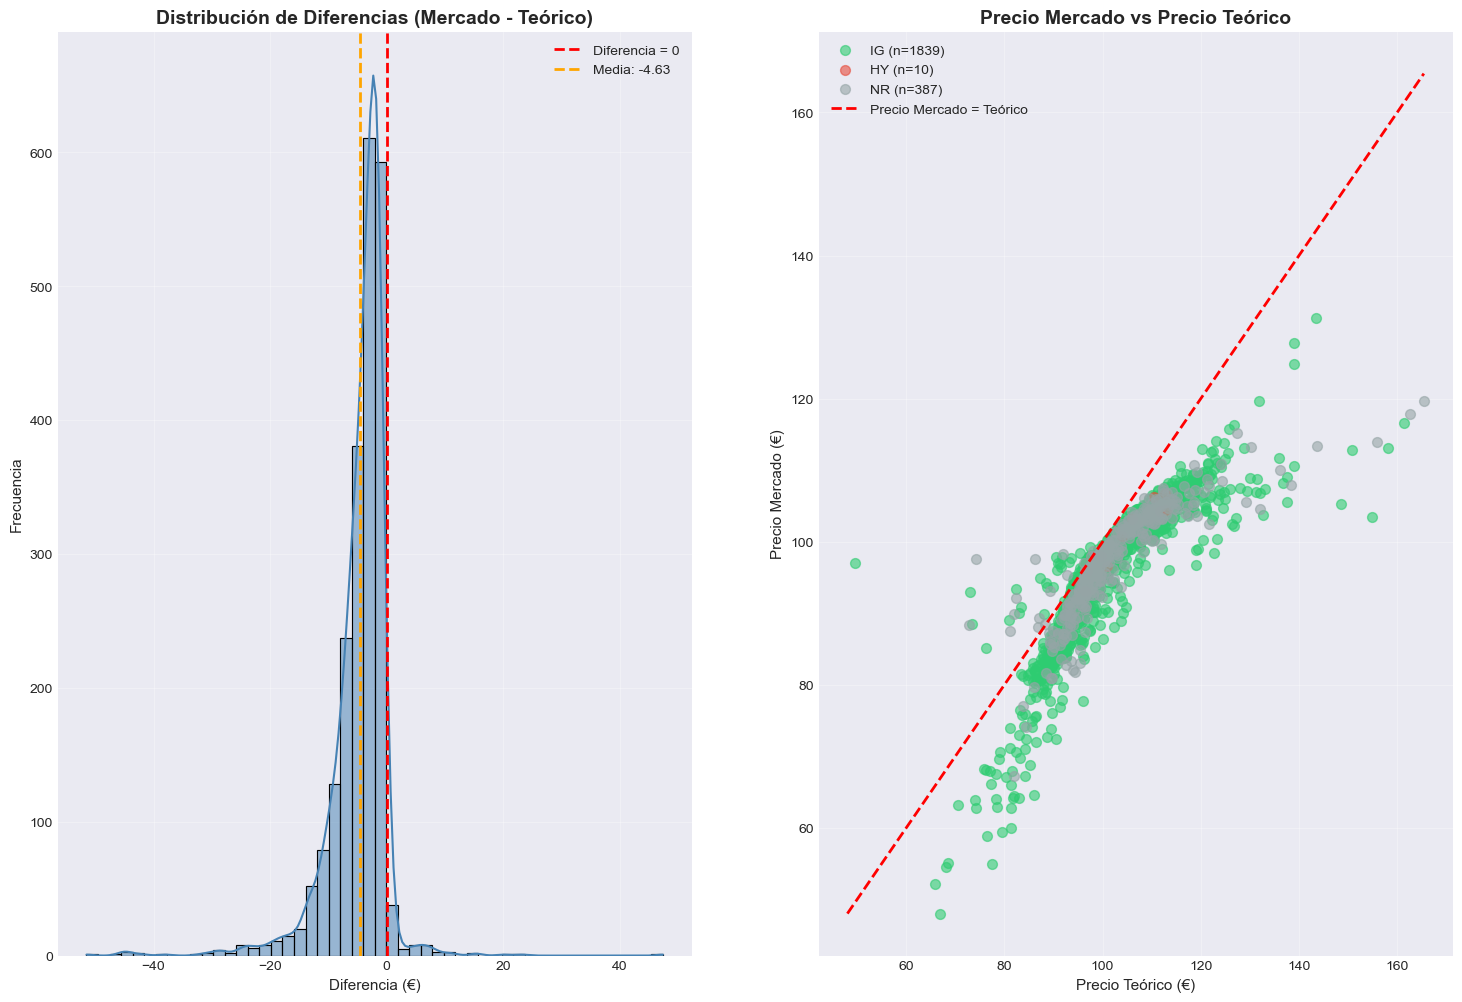

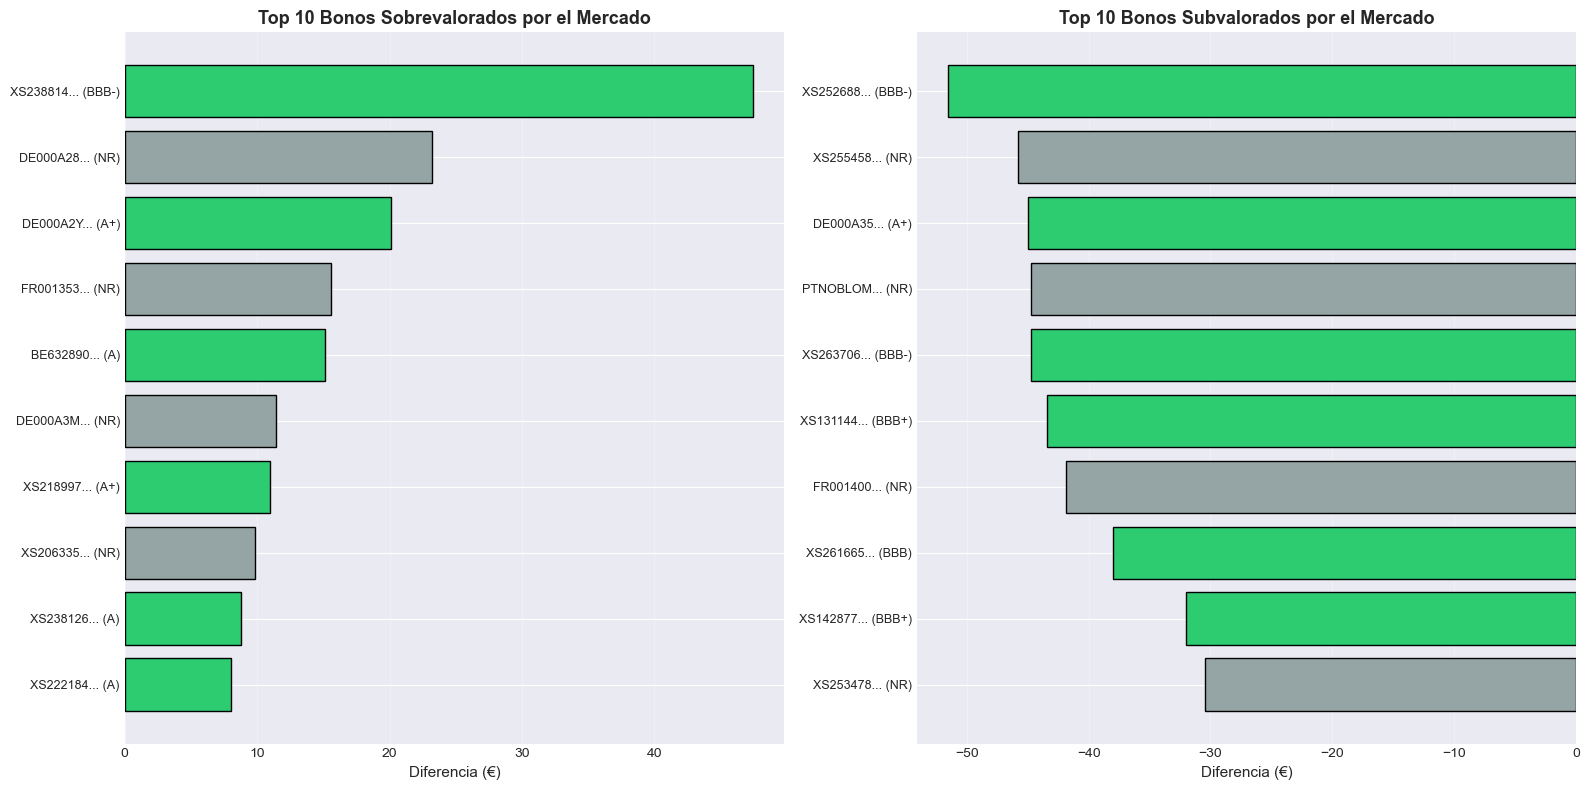


EJERCICIO 2 COMPLETADO


In [ ]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURACIÓN Y CONSTANTES - EJERCICIO 2
# ==============================================================================

FECHA_ANALISIS = pd.to_datetime('2025-10-01')
INVESTMENT_GRADE_RATINGS = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-'
]

# ==============================================================================
# FUNCIONES DE INTERPOLACIÓN Y VALORACIÓN
# ==============================================================================

def interpolate_discount_factor(curva, fecha_valor, fecha_pago):
    """
    Interpola el factor de descuento usando interpolación log-lineal.
    """
    dias_valor = (fecha_pago - fecha_valor).days
    if dias_valor <= 0:
        return 1.0
    
    fechas_curva = curva.index
    factores_curva = curva['Discount'].values
    
    # Filtrar factores válidos
    valid_mask = factores_curva > 0
    if not np.any(valid_mask) or np.sum(valid_mask) < 2:
        return 1.0
    
    factores_validos = factores_curva[valid_mask]
    fechas_validas = fechas_curva[valid_mask]
    
    # Convertir a años
    años_curva = np.array([(f - fecha_valor).days / 365.0 for f in fechas_validas])
    años_pago = dias_valor / 365.0
    
    # Logaritmo de factores para interpolación exponencial
    log_factores = np.log(factores_validos)
    
    # Extrapolación para plazos cortos
    if años_pago <= años_curva[0]:
        if años_curva[0] == 0:
            return 1.0
        return factores_validos[0] ** (años_pago / años_curva[0])
    
    # Extrapolación para plazos largos
    elif años_pago >= años_curva[-1]:
        return factores_validos[-1] ** (años_pago / años_curva[-1])
    
    # Interpolación lineal en espacio logarítmico
    else:
        interp_func = interpolate.interp1d(
            años_curva, log_factores, 
            kind='linear', 
            fill_value='extrapolate'
        )
        log_df = interp_func(años_pago)
        return np.exp(log_df)


def generar_fechas_cupon(bono, fecha_valor):
    """Genera todas las fechas de cupón futuras para un bono."""
    freq_cupon = bono['Coupon Frequency']
    fecha_vencimiento = bono['Maturity']
    fecha_primer_cupon = bono['First Coupon Date']
    
    # Determinar incremento de fecha según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar próxima fecha de cupón después de fecha_valor
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_valor:
        fecha_actual += offset
    
    # Generar todas las fechas hasta vencimiento
    fechas_cupon = []
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        fecha_actual += offset
    
    # Asegurar que incluye el vencimiento
    if not fechas_cupon or fechas_cupon[-1] != fecha_vencimiento:
        if fecha_vencimiento > fecha_valor:
            fechas_cupon.append(fecha_vencimiento)
    
    return sorted(list(set(fechas_cupon)))


def calcular_cupon_corrido(bono, fecha_valor):
    """Calcula el cupón corrido (accrued interest) en la fecha de valoración."""
    freq_cupon = bono['Coupon Frequency']
    cupon_rate = bono['Coupon']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Determinar offset según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar fecha de cupón anterior
    fecha_temp = bono['First Coupon Date']
    fecha_cupon_anterior = None
    
    while fecha_temp < fecha_valor:
        fecha_cupon_anterior = fecha_temp
        fecha_temp += offset
    
    if fecha_cupon_anterior is None or fecha_cupon_anterior >= fecha_valor:
        return 0.0
    
    # Calcular días transcurridos
    dias_desde_cupon = (fecha_valor - fecha_cupon_anterior).days
    dias_periodo = (fecha_temp - fecha_cupon_anterior).days
    
    if dias_periodo <= 0:
        return 0.0
    
    return cupon_monto_periodico * (dias_desde_cupon / dias_periodo)


def valorar_bono(bono, curva, fecha_valor, spread_credito=0):
    """Valora un bono usando descuento de flujos de caja."""
    # Validar datos esenciales
    if pd.isna(bono['Coupon']) or pd.isna(bono['Coupon Frequency']):
        raise ValueError("Datos de cupón incompletos")
    
    if pd.isna(bono['Maturity']):
        raise ValueError("Fecha de vencimiento no disponible")
    
    fecha_vencimiento = bono['Maturity']
    if fecha_vencimiento <= fecha_valor:
        return {'precio_limpio': 100.0, 'cupon_corrido': 0.0, 'precio_sucio': 100.0}
    
    # Parámetros del bono
    cupon_rate = bono['Coupon']
    freq_cupon = bono['Coupon Frequency']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Generar fechas de pago
    fechas_cupon = generar_fechas_cupon(bono, fecha_valor)
    
    if not fechas_cupon:
        raise ValueError("No se pudieron generar fechas de cupón")
    
    # Valorar flujos de caja
    vp_total = 0.0
    spread_anual = spread_credito / 10000.0
    
    for i, fecha_pago in enumerate(fechas_cupon):
        dias = (fecha_pago - fecha_valor).days
        if dias <= 0:
            continue
        
        # Factor de descuento de la curva
        df = interpolate_discount_factor(curva, fecha_valor, fecha_pago)
        
        # Ajuste por spread de crédito
        t_años = dias / 365.0
        df_ajustado = df * np.exp(-spread_anual * t_años)
        
        # Flujo de caja
        if i == len(fechas_cupon) - 1:  # Último pago
            flujo = cupon_monto_periodico + 100.0  # Cupón + Principal
        else:
            flujo = cupon_monto_periodico
        
        vp_total += flujo * df_ajustado
    
    precio_limpio = vp_total
    cupon_corrido = calcular_cupon_corrido(bono, fecha_valor)
    precio_sucio = precio_limpio + cupon_corrido
    
    return {
        'precio_limpio': precio_limpio,
        'cupon_corrido': cupon_corrido,
        'precio_sucio': precio_sucio
    }


def clasificar_rating(rating):
    """Clasifica un rating como IG, HY o NR."""
    if pd.isna(rating) or rating == 'NR':
        return 'NR'
    rating_upper = str(rating).strip().upper()
    return 'IG' if rating_upper in INVESTMENT_GRADE_RATINGS else 'HY'


def preparar_datos(universo_df, curva_estr_df):
    """Prepara los datos ya cargados en memoria."""
    # Trabajar con una copia para no modificar el original
    universo = universo_df.copy()
    
    # Convertir fechas si no están ya en formato datetime
    campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 
                    'Penultimate Coupon Date', 'Issue date']
    for campo in campos_fecha:
        if campo in universo.columns:
            if not pd.api.types.is_datetime64_any_dtype(universo[campo]):
                universo[campo] = pd.to_datetime(
                    universo[campo].replace('', pd.NA), 
                    format='%d/%m/%Y', 
                    errors='coerce'
                )
    
    # Preparar curva ESTR
    curva_estr = curva_estr_df.copy()
    
    # Detectar la estructura del DataFrame de la curva
    if 'Date' in curva_estr.columns and 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr['Date']):
            curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
        curva_estr.set_index('Date', inplace=True)
    elif 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            curva_estr.index = pd.to_datetime(curva_estr.index, format='%d/%m/%Y', errors='coerce')
    else:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            primera_col = curva_estr.columns[0]
            curva_estr[primera_col] = pd.to_datetime(curva_estr[primera_col], errors='coerce')
            curva_estr.set_index(primera_col, inplace=True)
        
        discount_cols = [col for col in curva_estr.columns if 'discount' in col.lower()]
        if discount_cols:
            curva_estr = curva_estr.rename(columns={discount_cols[0]: 'Discount'})
        else:
            numeric_cols = curva_estr.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                curva_estr = curva_estr.rename(columns={numeric_cols[0]: 'Discount'})
    
    if 'Discount' not in curva_estr.columns:
        raise ValueError("No se pudo identificar la columna 'Discount' en la curva ESTR")
    
    # Filtrar curva para fechas futuras y eliminar nulos
    curva_fecha = curva_estr.loc[curva_estr.index >= FECHA_ANALISIS].copy()
    curva_fecha = curva_fecha.dropna(subset=['Discount'])
    
    if len(curva_fecha) == 0:
        raise ValueError(f"No hay datos de curva ESTR para fechas >= {FECHA_ANALISIS}")
    
    return universo, curva_fecha


# ==============================================================================
# EJERCICIO 2: VALORACIÓN Y VISUALIZACIONES
# ==============================================================================

def ejecutar_ejercicio_2(universo_df, curva_estr_df):
    """
    Ejecuta el Ejercicio 2: Valoración de bonos con spread = 0.
    Genera análisis completo y visualizaciones.
    """
    print("=" * 80)
    print("EJERCICIO 2: VALORACIÓN DE BONOS CORPORATIVOS")
    print(f"Fecha de análisis: {FECHA_ANALISIS.strftime('%d/%m/%Y')}")
    print("=" * 80)
    
    # 1. Preparar datos
    print("\n[1/3] Preparando datos...")
    universo, curva_fecha = preparar_datos(universo_df, curva_estr_df)
    print(f"✓ Universo preparado: {len(universo)} bonos")
    print(f"✓ Curva ESTR: {len(curva_fecha)} puntos")
    
    # 2. Filtrar bonos válidos
    bonos_validos = universo[
        universo['Price'].notna() & 
        universo['Coupon'].notna() &
        universo['Coupon Frequency'].notna() & 
        universo['Maturity'].notna() &
        (universo['Maturity'] > FECHA_ANALISIS)
    ].copy()
    
    print(f"\n[2/3] Valorando bonos...")
    print(f"Bonos válidos para valoración: {len(bonos_validos)}")
    
    # 3. Valorar cada bono
    resultados = []
    for idx, bono in bonos_validos.iterrows():
        try:
            valoracion = valorar_bono(bono, curva_fecha, FECHA_ANALISIS, spread_credito=0)
            
            if valoracion['precio_limpio'] > 0:
                precio_mercado = bono['Price']
                precio_teorico = valoracion['precio_limpio']
                
                resultados.append({
                    'ISIN': bono['ISIN'],
                    'Rating': bono['Rating'],
                    'Coupon': bono['Coupon'],
                    'Maturity': bono['Maturity'],
                    'Precio_Mercado': precio_mercado,
                    'Precio_Teorico': precio_teorico,
                    'Diferencia': precio_mercado - precio_teorico,
                    'Diferencia_%': ((precio_mercado - precio_teorico) / precio_teorico) * 100,
                    'Error_Abs': abs(precio_mercado - precio_teorico)
                })
        except Exception as e:
            continue
    
    df_valoracion = pd.DataFrame(resultados)
    df_valoracion['Rating_Class'] = df_valoracion['Rating'].apply(clasificar_rating)
    
    # 4. Estadísticas
    print(f"\n[3/3] Generando análisis y visualizaciones...")
    print(f"\n✓ Bonos valorados exitosamente: {len(df_valoracion)}")
    print("\n" + "=" * 80)
    print("ESTADÍSTICAS DE VALORACIÓN")
    print("=" * 80)
    print("\nDiferencia (Precio Mercado - Precio Teórico):")
    print(df_valoracion['Diferencia'].describe().round(2))
    print(f"\nRMSE: {np.sqrt((df_valoracion['Diferencia']**2).mean()):.2f}")
    print(f"MAE: {df_valoracion['Error_Abs'].mean():.2f}")
    
    # Análisis por Rating
    print("\n" + "=" * 80)
    print("ANÁLISIS POR RATING CLASS")
    print("=" * 80)
    analisis_rating = df_valoracion.groupby('Rating_Class').agg({
        'Diferencia': ['count', 'mean', 'std', 'min', 'max'],
        'Error_Abs': 'mean',
        'Diferencia_%': ['mean', 'std']
    }).round(2)
    print(analisis_rating)
    
    # 5. VISUALIZACIONES
    crear_visualizaciones_ejercicio_2(df_valoracion)
    
    print("\n" + "=" * 80)
    print("EJERCICIO 2 COMPLETADO")
    print("=" * 80)
    
    # Devolver también los datos necesarios para el Ejercicio 3
    return {
        'df_valoracion': df_valoracion,
        'universo': universo,
        'curva_fecha': curva_fecha
    }


def crear_visualizaciones_ejercicio_2(df_valoracion):
    """Crea todas las visualizaciones para el Ejercicio 2."""
    
    # Configuración de estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    colores = {
        'IG': '#2ecc71',  # Verde
        'HY': '#e74c3c',  # Rojo
        'NR': '#95a5a6'   # Gris
    }
    
    # =========================================================================
    # FIGURA 1: Análisis de Diferencias (4 gráficos)
    # =========================================================================
    fig1 = plt.figure(figsize=(18, 12))
    
    # 1.1 Histograma de diferencias
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df_valoracion['Diferencia'], bins=50, kde=True, 
                 color='steelblue', edgecolor='black', ax=ax1)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Diferencia = 0')
    ax1.axvline(df_valoracion['Diferencia'].mean(), color='orange', 
                linestyle='--', linewidth=2, 
                label=f'Media: {df_valoracion["Diferencia"].mean():.2f}')
    ax1.set_title('Distribución de Diferencias (Mercado - Teórico)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Diferencia (€)', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 1.2 Scatter: Precio Mercado vs Teórico
    ax2 = plt.subplot(1, 2, 2)
    for rating_class in ['IG', 'HY', 'NR']:
        data = df_valoracion[df_valoracion['Rating_Class'] == rating_class]
        ax2.scatter(data['Precio_Teorico'], data['Precio_Mercado'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=f'{rating_class} (n={len(data)})')
    
    # Línea de identidad (precio mercado = precio teórico)
    min_val = min(df_valoracion['Precio_Teorico'].min(), 
                  df_valoracion['Precio_Mercado'].min())
    max_val = max(df_valoracion['Precio_Teorico'].max(), 
                  df_valoracion['Precio_Mercado'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', 
             linewidth=2, label='Precio Mercado = Teórico')
    
    ax2.set_title('Precio Mercado vs Precio Teórico', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Precio Teórico (€)', fontsize=11)
    ax2.set_ylabel('Precio Mercado (€)', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # =========================================================================
    # FIGURA 3: Top Bonos con Mayor Desviación
    # =========================================================================
    fig3 = plt.figure(figsize=(16, 8))
    
    # Top 20 sobrevalorados y subvalorados
    top_sobrevalorados = df_valoracion.nlargest(10, 'Diferencia')
    top_subvalorados = df_valoracion.nsmallest(10, 'Diferencia')
    
    # 3.1 Top Sobrevalorados
    ax8 = plt.subplot(1, 2, 1)
    y_pos = np.arange(len(top_sobrevalorados))
    colors_sv = [colores[rc] for rc in top_sobrevalorados['Rating_Class']]
    ax8.barh(y_pos, top_sobrevalorados['Diferencia'].values, color=colors_sv, 
             edgecolor='black', linewidth=1)
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_sobrevalorados['ISIN'], top_sobrevalorados['Rating'])],
                        fontsize=9)
    ax8.set_xlabel('Diferencia (€)', fontsize=11)
    ax8.set_title('Top 10 Bonos Sobrevalorados por el Mercado', 
                  fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='x')
    ax8.invert_yaxis()
    
    # 3.2 Top Subvalorados
    ax9 = plt.subplot(1, 2, 2)
    y_pos = np.arange(len(top_subvalorados))
    colors_sub = [colores[rc] for rc in top_subvalorados['Rating_Class']]
    ax9.barh(y_pos, top_subvalorados['Diferencia'].values, color=colors_sub, 
             edgecolor='black', linewidth=1)
    ax9.set_yticks(y_pos)
    ax9.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_subvalorados['ISIN'], top_subvalorados['Rating'])],
                        fontsize=9)
    ax9.set_xlabel('Diferencia (€)', fontsize=11)
    ax9.set_title('Top 10 Bonos Subvalorados por el Mercado', 
                  fontsize=13, fontweight='bold')
    ax9.grid(True, alpha=0.3, axis='x')
    ax9.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('ejercicio2_top_desviaciones.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: 'ejercicio2_top_desviaciones.png'")
    plt.show()


# ==============================================================================
# INSTRUCCIONES DE USO
# ==============================================================================
# 
# Para ejecutar el Ejercicio 2:
resultados_ej2 = ejecutar_ejercicio_2(universo, curva_estr)
#
# Esto generará:
# - Análisis completo de la valoración
# - 3 archivos de gráficos en alta resolución
# - DataFrame con todos los resultados

1. Si los precios de mercado son sistemáticamente diferentes a los teóricos con spread=0,
   esto indica que los bonos tienen un spread de crédito positivo.

2. Otros factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de la emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>


EJERCICIO 3: CÁLCULO DE SPREADS DE CRÉDITO

Calculando spreads para 2236 bonos...
Progreso: 500/2236 bonos procesados (22.4%)
Progreso: 1000/2236 bonos procesados (44.7%)
Progreso: 1500/2236 bonos procesados (67.1%)
Progreso: 2000/2236 bonos procesados (89.4%)

✓ Spreads calculados exitosamente: 2236/2236 bonos

ESTADÍSTICAS DE SPREADS DE CRÉDITO (bp)
count    2236.00
mean      107.51
std        66.79
min         0.00
25%        68.65
50%        94.85
75%       130.35
max       624.07
Name: Spread_Credit_bp, dtype: float64

ANÁLISIS POR CLASIFICACIÓN DE RATING
              count    mean  median    std    min     max
Rating_Class                                             
HY               10  141.22  126.94  61.36  33.94  251.62
IG             1839  103.95   93.14  60.71   0.00  564.68
NR              387  123.59  102.52  88.56   0.00  624.07

✓ Gráfico guardado: 'ejercicio3_analisis_spreads.png'


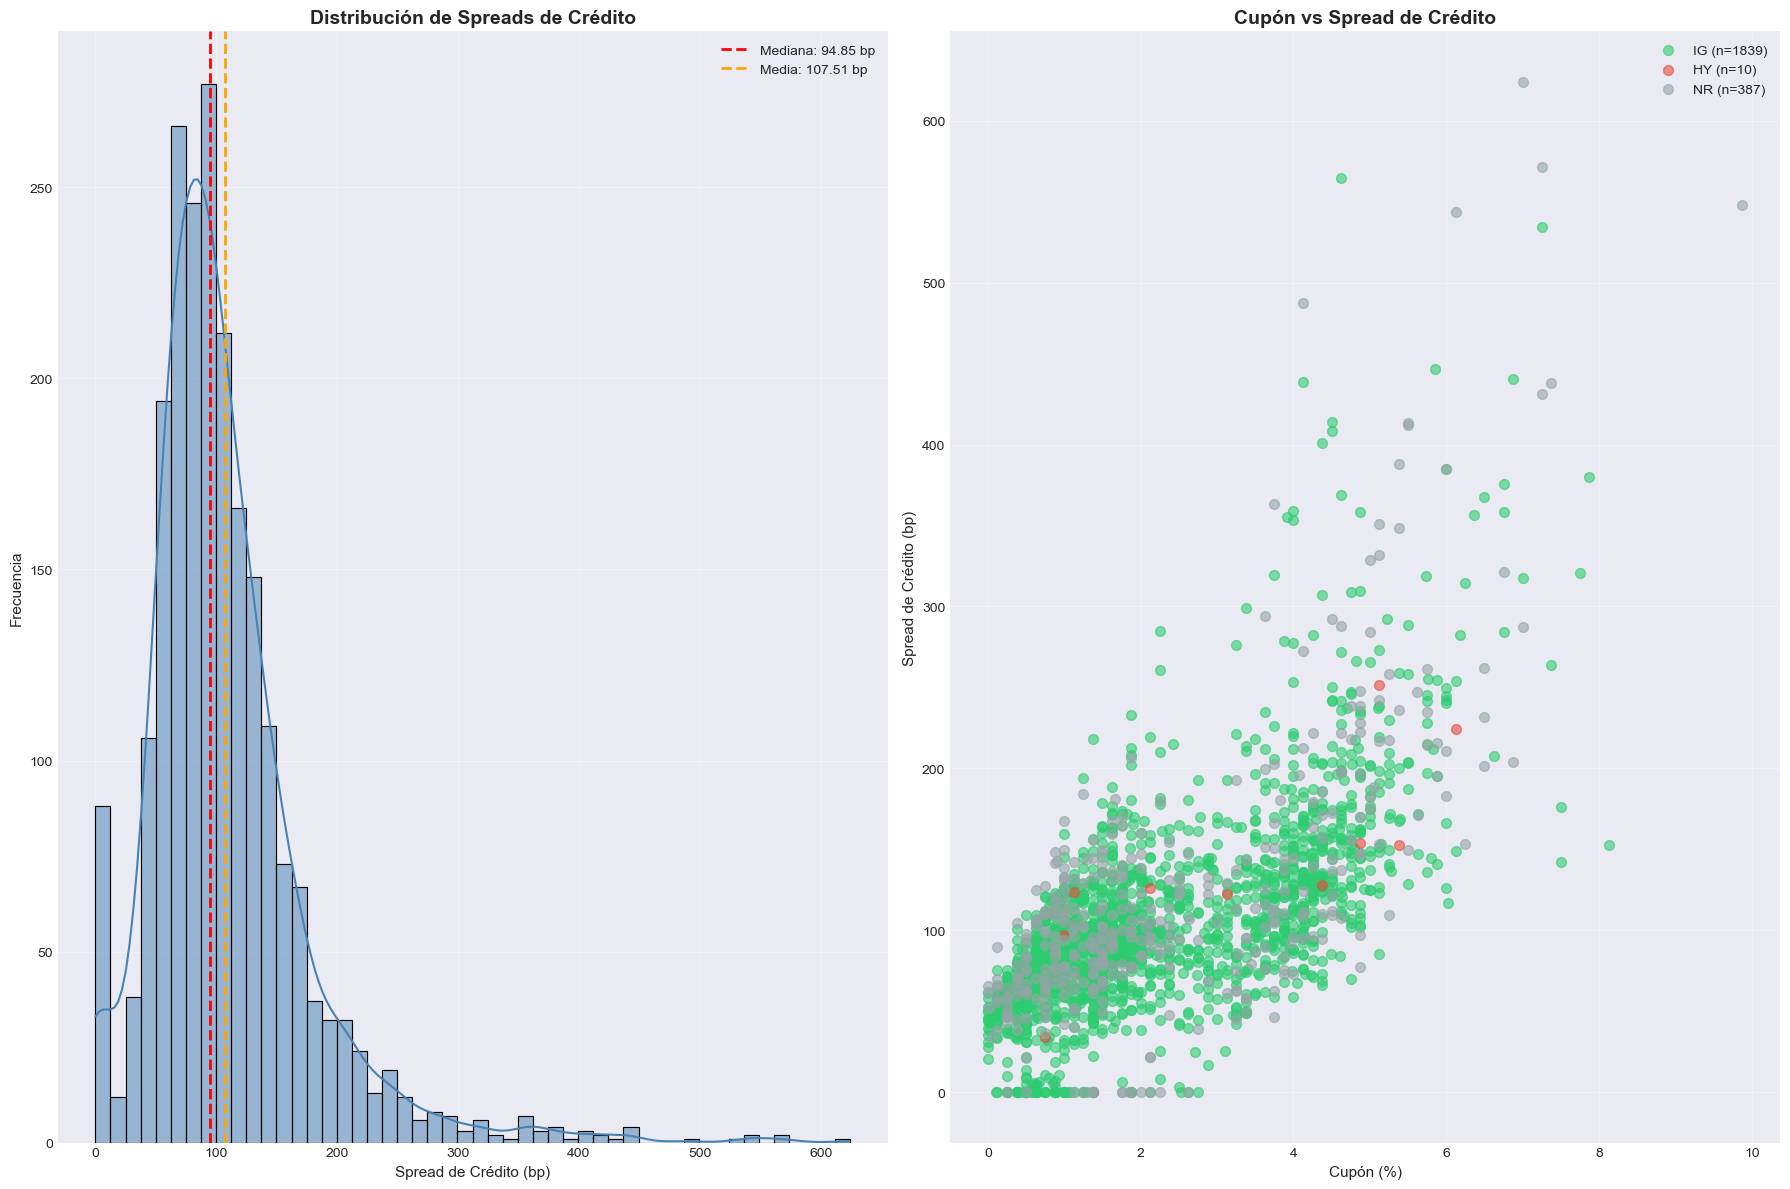

✓ Gráfico guardado: 'ejercicio3_analisis_comparativo.png'


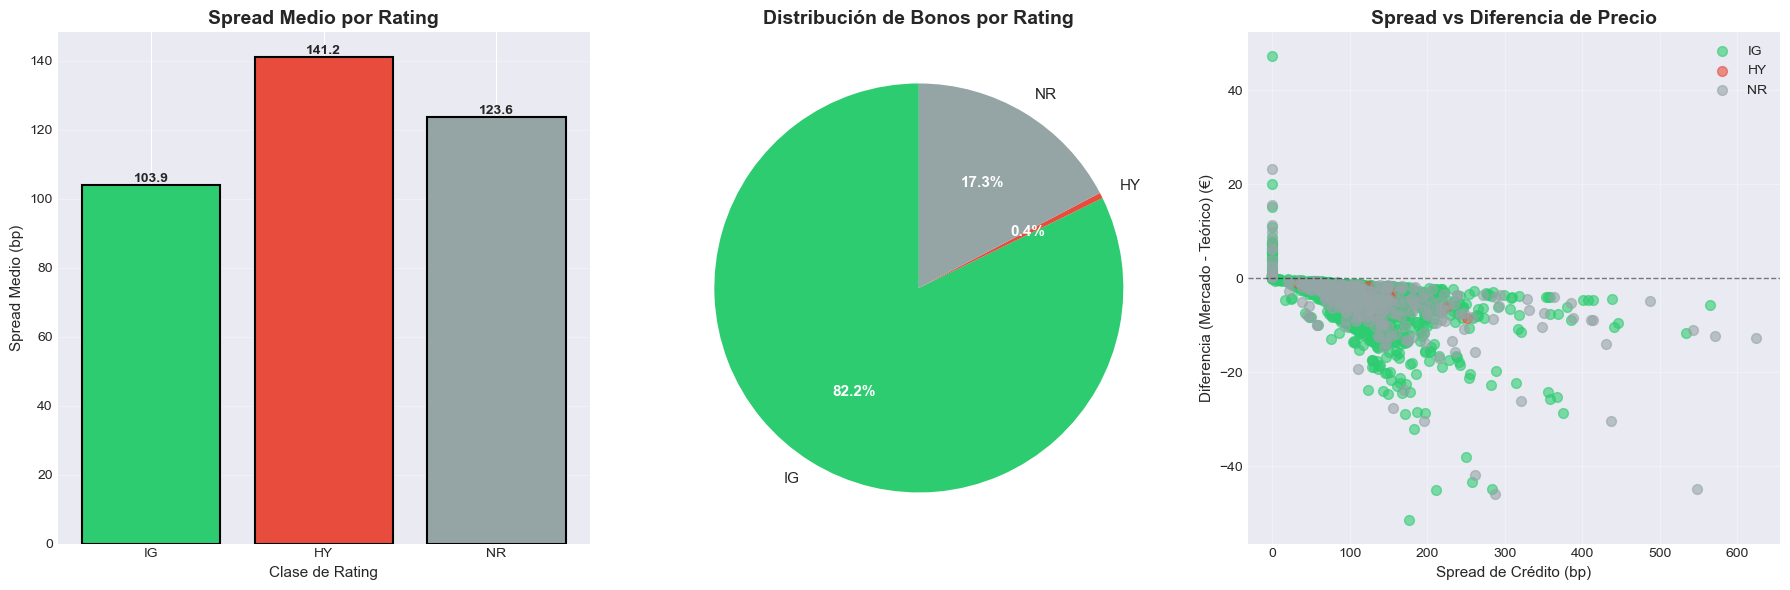


EJERCICIO 3 COMPLETADO


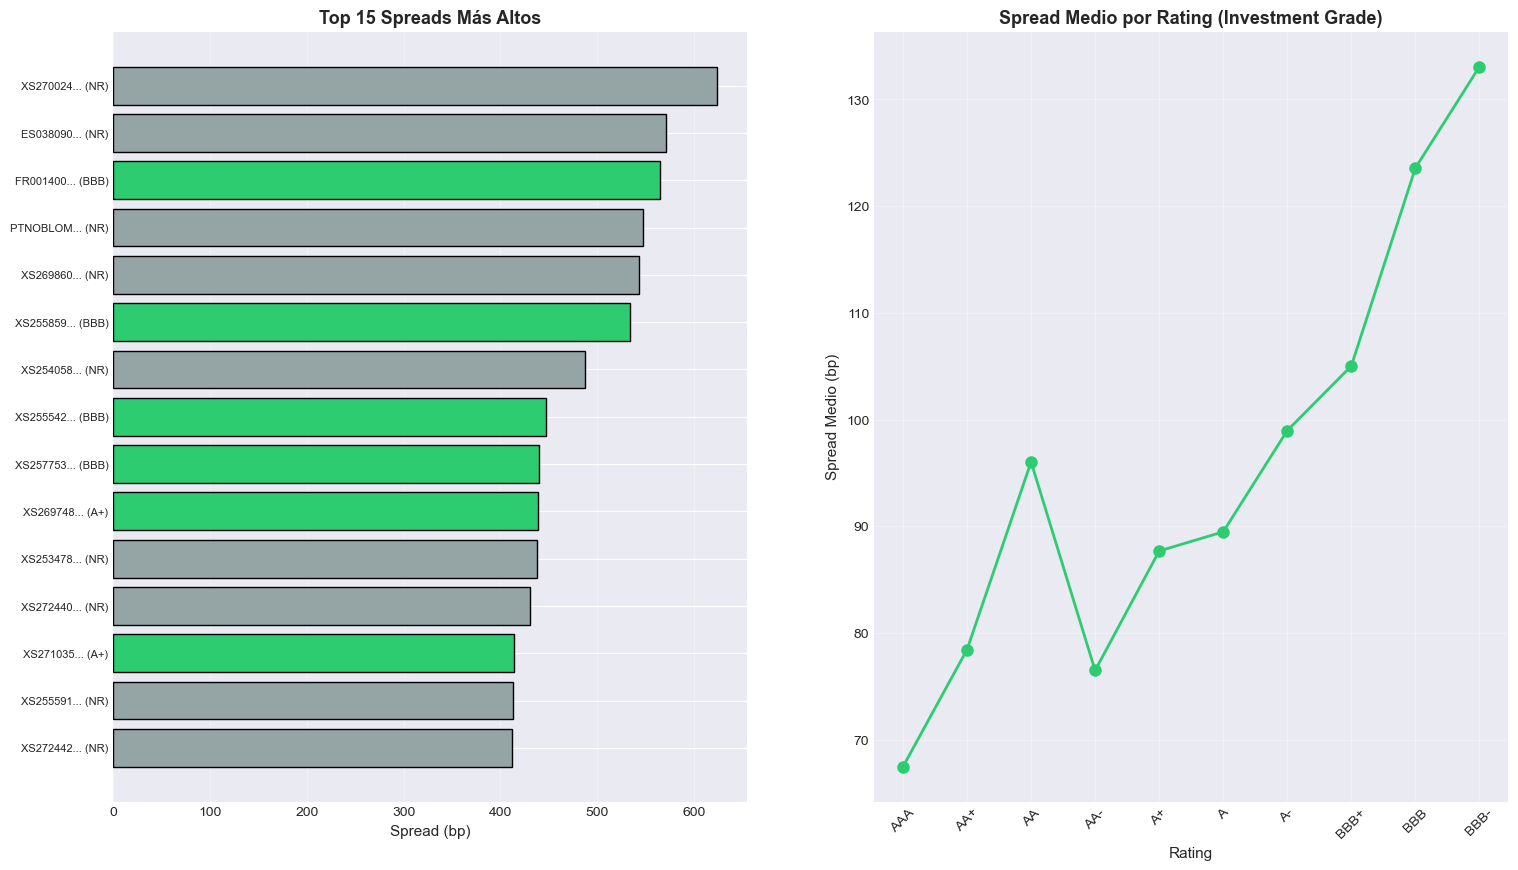

In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, brentq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# NOTA: Este script requiere que primero ejecutes el Ejercicio 2
# ==============================================================================
# 
# Debes tener disponible:
# 1. El DataFrame df_valoracion del Ejercicio 2
# 2. Los DataFrames universo y curva_estr originales
# 3. Las funciones de valoración del Ejercicio 2
#
# Si no has ejecutado el Ejercicio 2, primero ejecuta:
# df_valoracion = ejecutar_ejercicio_2(universo, curva_estr)
# ==============================================================================

FECHA_ANALISIS = pd.to_datetime('2025-10-01')
INVESTMENT_GRADE_RATINGS = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-'
]

# ==============================================================================
# FUNCIONES PARA EL EJERCICIO 3
# ==============================================================================

def calcular_spread_credito(bono, curva, fecha_valor, precio_mercado, valorar_bono_func):
    """
    Calcula el spread de crédito implícito usando método de Brent.
    
    Args:
        bono: Series con información del bono
        curva: DataFrame con curva de descuento
        fecha_valor: Fecha de valoración
        precio_mercado: Precio de mercado observado
        valorar_bono_func: Función de valoración del bono
        
    Returns:
        Spread de crédito en puntos básicos
    """
    def precio_diferencia(spread):
        try:
            valoracion = valorar_bono_func(bono, curva, fecha_valor, spread_credito=spread)
            return valoracion['precio_limpio'] - precio_mercado
        except:
            return 1e10
    
    try:
        # Usar método de Brent (más robusto que fsolve)
        spread_optimo = brentq(
            precio_diferencia, 
            a=0.0, 
            b=2000.0,  # Máximo 2000 bp
            xtol=0.01,
            maxiter=100
        )
        return max(0.0, spread_optimo)
    except:
        # Si Brent falla, intentar con fsolve
        try:
            spread_optimo = fsolve(precio_diferencia, x0=100.0, xtol=1e-6)[0]
            return max(0.0, spread_optimo)
        except:
            return np.nan


def clasificar_rating(rating):
    """Clasifica un rating como IG, HY o NR."""
    if pd.isna(rating) or rating == 'NR':
        return 'NR'
    rating_upper = str(rating).strip().upper()
    return 'IG' if rating_upper in INVESTMENT_GRADE_RATINGS else 'HY'


# ==============================================================================
# EJERCICIO 3: CÁLCULO DE SPREADS
# ==============================================================================

def ejecutar_ejercicio_3(df_valoracion, universo_df, curva_fecha, valorar_bono_func):
    """
    Ejecuta el Ejercicio 3: Cálculo de spreads de crédito.
    
    Args:
        df_valoracion: DataFrame del Ejercicio 2 con las valoraciones
        universo_df: DataFrame completo del universo de bonos
        curva_fecha: Curva ESTR filtrada
        valorar_bono_func: Función valorar_bono del Ejercicio 2
        
    Returns:
        DataFrame con los spreads calculados
    """
    print("\n" + "=" * 80)
    print("EJERCICIO 3: CÁLCULO DE SPREADS DE CRÉDITO")
    print("=" * 80)
    
    spreads = []
    total = len(df_valoracion)
    
    print(f"\nCalculando spreads para {total} bonos...")
    
    for idx, row in df_valoracion.iterrows():
        bono = universo_df[universo_df['ISIN'] == row['ISIN']].iloc[0]
        
        try:
            spread = calcular_spread_credito(
                bono, 
                curva_fecha, 
                FECHA_ANALISIS, 
                row['Precio_Mercado'],
                valorar_bono_func
            )
            spreads.append(spread)
        except:
            spreads.append(np.nan)
        
        # Progreso cada 500 bonos
        if (idx + 1) % 500 == 0:
            print(f"Progreso: {idx + 1}/{total} bonos procesados ({(idx+1)/total*100:.1f}%)")
    
    # Crear DataFrame con spreads
    df_spreads = df_valoracion.copy()
    df_spreads['Spread_Credit_bp'] = spreads
    df_spreads = df_spreads.dropna(subset=['Spread_Credit_bp'])
    df_spreads['Rating_Class'] = df_spreads['Rating'].apply(clasificar_rating)
    
    print(f"\n✓ Spreads calculados exitosamente: {len(df_spreads)}/{total} bonos")
    
    # Estadísticas
    print("\n" + "=" * 80)
    print("ESTADÍSTICAS DE SPREADS DE CRÉDITO (bp)")
    print("=" * 80)
    print(df_spreads['Spread_Credit_bp'].describe().round(2))
    
    # Análisis por Rating
    print("\n" + "=" * 80)
    print("ANÁLISIS POR CLASIFICACIÓN DE RATING")
    print("=" * 80)
    analisis_rating = df_spreads.groupby('Rating_Class')['Spread_Credit_bp'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    print(analisis_rating)
    
    # Crear visualizaciones
    crear_visualizaciones_ejercicio_3(df_spreads)
    
    print("\n" + "=" * 80)
    print("EJERCICIO 3 COMPLETADO")
    print("=" * 80)
    
    return df_spreads


def crear_visualizaciones_ejercicio_3(df_spreads):
    """Crea todas las visualizaciones para el Ejercicio 3."""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    colores = {
        'IG': '#2ecc71',  # Verde
        'HY': '#e74c3c',  # Rojo
        'NR': '#95a5a6'   # Gris
    }
    
    # =========================================================================
    # FIGURA 1: Análisis de Spreads (4 gráficos)
    # =========================================================================
    fig1 = plt.figure(figsize=(18, 12))
    
    # 1.1 Histograma de spreads
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df_spreads['Spread_Credit_bp'], bins=50, kde=True, 
                 color='steelblue', edgecolor='black', ax=ax1)
    mediana = df_spreads['Spread_Credit_bp'].median()
    media = df_spreads['Spread_Credit_bp'].mean()
    ax1.axvline(mediana, color='red', linestyle='--', linewidth=2, 
                label=f'Mediana: {mediana:.2f} bp')
    ax1.axvline(media, color='orange', linestyle='--', linewidth=2, 
                label=f'Media: {media:.2f} bp')
    ax1.set_title('Distribución de Spreads de Crédito', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Spread de Crédito (bp)', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    

    order = ['IG', 'HY', 'NR']

    # 1.4 Scatter: Cupón vs Spread
    ax4 = plt.subplot(1, 2, 2)
    for rating_class in order:
        data = df_spreads[df_spreads['Rating_Class'] == rating_class]
        ax4.scatter(data['Coupon'], data['Spread_Credit_bp'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=f'{rating_class} (n={len(data)})')
    ax4.set_title('Cupón vs Spread de Crédito', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Cupón (%)', fontsize=11)
    ax4.set_ylabel('Spread de Crédito (bp)', fontsize=11)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ejercicio3_analisis_spreads.png', dpi=300, bbox_inches='tight')
    print("\n✓ Gráfico guardado: 'ejercicio3_analisis_spreads.png'")
    plt.show()
    
    # =========================================================================
    # FIGURA 2: Análisis Comparativo (3 gráficos)
    # =========================================================================
    fig2 = plt.figure(figsize=(18, 6))
    
    # 2.1 Spread Medio por Rating Class
    ax5 = plt.subplot(1, 3, 1)
    spread_medio = df_spreads.groupby('Rating_Class')['Spread_Credit_bp'].mean().reindex(order)
    bars = ax5.bar(range(len(spread_medio)), spread_medio.values,
                   color=[colores[rc] for rc in order], edgecolor='black', linewidth=1.5)
    ax5.set_xticks(range(len(spread_medio)))
    ax5.set_xticklabels(order)
    ax5.set_title('Spread Medio por Rating', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Clase de Rating', fontsize=11)
    ax5.set_ylabel('Spread Medio (bp)', fontsize=11)
    ax5.grid(True, alpha=0.3, axis='y')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 2.2 Conteo por Rating Class
    ax6 = plt.subplot(1, 3, 2)
    counts = df_spreads['Rating_Class'].value_counts().reindex(order)
    colors_pie = [colores[rc] for rc in order]
    wedges, texts, autotexts = ax6.pie(counts.values, labels=counts.index, 
                                         autopct='%1.1f%%', colors=colors_pie,
                                         startangle=90, textprops={'fontsize': 11})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax6.set_title('Distribución de Bonos por Rating', fontsize=14, fontweight='bold')
    
    # 2.3 Spread vs Diferencia de Precio
    ax7 = plt.subplot(1, 3, 3)
    for rating_class in order:
        data = df_spreads[df_spreads['Rating_Class'] == rating_class]
        ax7.scatter(data['Spread_Credit_bp'], data['Diferencia'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=rating_class)
    ax7.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax7.set_title('Spread vs Diferencia de Precio', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Spread de Crédito (bp)', fontsize=11)
    ax7.set_ylabel('Diferencia (Mercado - Teórico) (€)', fontsize=11)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ejercicio3_analisis_comparativo.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: 'ejercicio3_analisis_comparativo.png'")
    plt.show()
    
    # =========================================================================
    # FIGURA 3: Top Spreads y Análisis por Rating Individual
    # =========================================================================
    fig3 = plt.figure(figsize=(18, 10))
    
    # 3.1 Top 15 spreads más altos
    ax8 = plt.subplot(1, 2, 1)
    top_spreads = df_spreads.nlargest(15, 'Spread_Credit_bp')
    y_pos = np.arange(len(top_spreads))
    colors_top = [colores[rc] for rc in top_spreads['Rating_Class']]
    ax8.barh(y_pos, top_spreads['Spread_Credit_bp'].values, color=colors_top,
             edgecolor='black', linewidth=1)
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_spreads['ISIN'], top_spreads['Rating'])],
                        fontsize=8)
    ax8.set_xlabel('Spread (bp)', fontsize=11)
    ax8.set_title('Top 15 Spreads Más Altos', fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='x')
    ax8.invert_yaxis()

    
    # 3.3 Spread por Rating Individual (IG)
    ax10 = plt.subplot(1, 2, 2)
    ig_data = df_spreads[df_spreads['Rating_Class'] == 'IG']
    if len(ig_data) > 0:
        rating_order = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
        ig_by_rating = ig_data.groupby('Rating')['Spread_Credit_bp'].mean()
        ig_by_rating = ig_by_rating.reindex([r for r in rating_order if r in ig_by_rating.index])
        ax10.plot(range(len(ig_by_rating)), ig_by_rating.values, 
                 marker='o', linewidth=2, markersize=8, color='#2ecc71')
        ax10.set_xticks(range(len(ig_by_rating)))
        ax10.set_xticklabels(ig_by_rating.index, rotation=45)
        ax10.set_title('Spread Medio por Rating (Investment Grade)', 
                      fontsize=13, fontweight='bold')
        ax10.set_xlabel('Rating', fontsize=11)
        ax10.set_ylabel('Spread Medio (bp)', fontsize=11)
        ax10.grid(True, alpha=0.3)
    


# ==============================================================================
# INSTRUCCIONES DE USO
# ==============================================================================
# 
# Para ejecutar el Ejercicio 3 (después de haber ejecutado el Ejercicio 2):
#

#
# PASO 2: Ejecuta el Ejercicio 3 usando los resultados del Ejercicio 2
df_spreads = ejecutar_ejercicio_3(
    resultados_ej2['df_valoracion'], 
    resultados_ej2['universo'], 
    resultados_ej2['curva_fecha'],
    valorar_bono
)

# Esto generará:
# - Análisis completo de spreads de crédito
# - 4 archivos de gráficos en alta resolución
# - DataFrame con todos los spreads calculados

Los resultados sí tienen sentido, porque para ajustar la curva mediante un movimiento 
paralelo es necesario añadir un spread que recoja el riesgo de crédito del emisor. 
Este spread varía en función del rating, la probabilidad de impago, la liquidez y 
otras características del bono, por lo que es lógico que los valores calculados 
difieran entre instrumentos.

Para comprobar si los resultados son coherentes, los compararía con:

- Los precios de mercado reales de los bonos, para verificar que, una vez aplicados 
  los spreads, la valoración se aproxima al precio observado.
- El yield implícito o yield-to-maturity de mercado, ya que es otra forma de medir 
  qué prima de riesgo está descontando el mercado. Si los spreads calculados se 
  alinean con los yields implícitos, entonces la calibración es consistente.

En resumen, los spreads obtenidos son razonables porque incorporan el riesgo 
específico del emisor, y la validación natural es contrastarlos con los precios 
y yields de mercado para ver si efectivamente reproducen la realidad observada.


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [17]:
# ============================================================================
# EJERCICIO 4: YIELD, DURACIÓN Y CONVEXIDAD - VERSIÓN CORREGIDA
# ============================================================================
# Calculamos YTM, duración modificada y convexidad para cada bono
# ============================================================================


def calcular_ytm(bono, precio_mercado, fecha_valor, ytm_inicial=0.03, tol=1e-8):
    """
    Calcula el Yield to Maturity (YTM) del bono usando capitalización discreta.

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    precio_mercado : float, precio de mercado del bono
    fecha_valor : datetime, fecha de valoración
    ytm_inicial : float, YTM inicial para búsqueda
    tol : float, tolerancia para convergencia

    Retorna:
    --------
    float: YTM en decimal (ej: 0.03 para 3%)
    """
    # Determinar fecha de vencimiento (priorizar call si existe)
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    # Asegurar que la última fecha sea el vencimiento
    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    # Filtrar solo cupones futuros
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    cupon_periodo = cupon / freq_cupon

    def objetivo(ytm):
        """Función objetivo: diferencia entre precio teórico y mercado."""
        ytm_periodo = ytm / freq_cupon  # YTM por período
        vp = 0.0

        # Valor presente de cupones intermedios
        for i, fecha_cupon in enumerate(fechas_cupon[:-1], start=1):
            dias = (fecha_cupon - fecha_valor).days
            if dias > 0:
                # Calcular número de períodos (fraccional)
                periodos = dias / (365.0 / freq_cupon)
                vp += cupon_periodo * 100.0 / ((1 + ytm_periodo) ** periodos)

        # Último flujo: cupón + principal
        dias_ultimo = (fechas_cupon[-1] - fecha_valor).days
        if dias_ultimo > 0:
            periodos_ultimo = dias_ultimo / (365.0 / freq_cupon)
            vp += (cupon_periodo * 100.0 + 100.0) / ((1 + ytm_periodo) ** periodos_ultimo)

        return vp - precio_mercado

    try:
        # Intentar con brentq primero (más robusto con límites)
        if objetivo(0.0001) * objetivo(0.5) < 0:
            ytm = brentq(objetivo, 0.0001, 0.5, xtol=tol)
        else:
            ytm = fsolve(objetivo, ytm_inicial, xtol=tol)[0]
        return max(0.0, ytm)
    except:
        return np.nan


def calcular_duracion_macaulay(bono, fecha_valor, ytm):
    """
    Calcula la duración de Macaulay del bono.

    D_Mac = Σ(t * CF_t / (1+y)^t) / P

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    fecha_valor : datetime, fecha de valoración
    ytm : float, yield to maturity

    Retorna:
    --------
    float: Duración de Macaulay en años
    """
    if np.isnan(ytm):
        return np.nan

    # Determinar fecha de vencimiento
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    cupon_periodo = cupon / freq_cupon
    ytm_periodo = ytm / freq_cupon

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    # Calcular duración de Macaulay
    suma_vp_ponderado = 0.0
    suma_vp = 0.0

    for i, fecha_cupon in enumerate(fechas_cupon):
        dias = (fecha_cupon - fecha_valor).days
        if dias > 0:
            tiempo_anios = dias / 365.0
            periodos = dias / (365.0 / freq_cupon)

            # Flujo de caja (último incluye principal)
            if i == len(fechas_cupon) - 1:
                flujo = (cupon_periodo * 100.0 + 100.0)
            else:
                flujo = cupon_periodo * 100.0

            # VP del flujo
            vp_flujo = flujo / ((1 + ytm_periodo) ** periodos)

            # Acumular
            suma_vp_ponderado += tiempo_anios * vp_flujo
            suma_vp += vp_flujo

    if suma_vp > 0:
        duracion_macaulay = suma_vp_ponderado / suma_vp
        return duracion_macaulay
    else:
        return np.nan


def calcular_duracion_modificada(duracion_macaulay, ytm, freq_cupon):
    """
    Calcula la duración modificada del bono.

    D_mod = D_Mac / (1 + y/m)

    donde y es el YTM anual y m es la frecuencia de cupones.

    Parámetros:
    -----------
    duracion_macaulay : float, duración de Macaulay
    ytm : float, yield to maturity anual
    freq_cupon : int, frecuencia de cupones

    Retorna:
    --------
    float: Duración modificada
    """
    if np.isnan(duracion_macaulay) or np.isnan(ytm):
        return np.nan

    ytm_periodo = ytm / freq_cupon
    duracion_modificada = duracion_macaulay / (1 + ytm_periodo)

    return duracion_modificada


def calcular_convexidad(bono, fecha_valor, ytm):
    """
    Calcula la convexidad del bono.

    C = Σ(CF_t * t * (t+1) / (1+y)^(t+2)) / P

    Para períodos fraccionarios: t = días / (365/freq)

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    fecha_valor : datetime, fecha de valoración
    ytm : float, yield to maturity

    Retorna:
    --------
    float: Convexidad
    """
    if np.isnan(ytm):
        return np.nan

    # Determinar fecha de vencimiento
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    cupon_periodo = cupon / freq_cupon
    ytm_periodo = ytm / freq_cupon

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    # Calcular convexidad
    suma_convexidad = 0.0
    suma_vp = 0.0

    for i, fecha_cupon in enumerate(fechas_cupon):
        dias = (fecha_cupon - fecha_valor).days
        if dias > 0:
            periodos = dias / (365.0 / freq_cupon)

            # Flujo de caja
            if i == len(fechas_cupon) - 1:
                flujo = (cupon_periodo * 100.0 + 100.0)
            else:
                flujo = cupon_periodo * 100.0

            # VP del flujo
            vp_flujo = flujo / ((1 + ytm_periodo) ** periodos)

            # Término de convexidad: CF * t * (t+1) / (1+y)^(t+2)
            termino_convexidad = flujo * periodos * (periodos + 1) / ((1 + ytm_periodo) ** (periodos + 2))

            suma_convexidad += termino_convexidad
            suma_vp += vp_flujo

    if suma_vp > 0:
        convexidad = suma_convexidad / suma_vp
        # Ajustar por frecuencia de cupones (convexidad anualizada)
        convexidad = convexidad / (freq_cupon ** 2)
        return convexidad
    else:
        return np.nan


# ============================================================================
# CÁLCULO DE MÉTRICAS PARA TODOS LOS BONOS
# ============================================================================

print("=" * 80)
print("CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD")
print("=" * 80)

resultados_metricas = []

for idx, bono in universo.iterrows():
    try:
        precio_mercado = bono['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            continue

        # Calcular YTM
        ytm = calcular_ytm(bono, precio_mercado, fecha_analisis_dt)

        if np.isnan(ytm):
            continue

        # Calcular duración de Macaulay
        duracion_macaulay = calcular_duracion_macaulay(bono, fecha_analisis_dt, ytm)

        # Calcular duración modificada
        duracion_modificada = calcular_duracion_modificada(
            duracion_macaulay, ytm, bono['Coupon Frequency']
        )

        # Calcular convexidad
        convexidad = calcular_convexidad(bono, fecha_analisis_dt, ytm)

        # Obtener spread para comparación
        spread = df_spreads[df_spreads['ISIN'] == bono['ISIN']]['Spread_bp'].values
        spread_val = spread[0] if len(spread) > 0 else np.nan

        # Calcular tiempo hasta vencimiento
        if pd.notna(bono.get('Next Call Date')):
            fecha_venc = pd.to_datetime(bono['Next Call Date'])
        else:
            fecha_venc = pd.to_datetime(bono['Maturity'])
        tiempo_vencimiento = (fecha_venc - fecha_analisis_dt).days / 365.0

        resultados_metricas.append({
            'ISIN': bono['ISIN'],
            'Precio_Mercado': precio_mercado,
            'YTM_%': ytm * 100,
            'Duracion_Macaulay': duracion_macaulay,
            'Duracion': duracion_modificada,  # Nombre compatible con código posterior
            'Duracion_Modificada': duracion_modificada,
            'Convexidad': convexidad,
            'Spread_bp': spread_val,
            'Rating': bono.get('Rating', 'NR'),
            'Rating_Class': bono.get('Rating_Class', 'NR'),  # Añadido para compatibilidad
            'Tiempo_Vencimiento': tiempo_vencimiento,
            'Cupon_%': bono['Coupon'],
            'Frecuencia': bono['Coupon Frequency']
        })
    except Exception as e:
        print(f"Error procesando {bono.get('ISIN', 'N/A')}: {str(e)}")
        continue

df_metricas = pd.DataFrame(resultados_metricas)

print(f"\nBonos procesados exitosamente: {len(df_metricas)}")
print(f"\nEstadísticas de YTM (%):")
print(df_metricas['YTM_%'].describe())
print(f"\nEstadísticas de Duración Modificada (años):")
print(df_metricas['Duracion'].describe())  # Usar 'Duracion' para compatibilidad
print(f"\nEstadísticas de Convexidad:")
print(df_metricas['Convexidad'].describe())

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 9))
fig.suptitle('Análisis de YTM, Duración y Convexidad', fontsize=16, fontweight='bold')

# 1. Distribución de YTM
axes[0].hist(df_metricas['YTM_%'].dropna(), bins=50, color='cyan',
                edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de YTM', fontweight='bold')
axes[0].set_xlabel('YTM (%)')
axes[0].set_ylabel('Frecuencia (Escala logarítmica)')
axes[0].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[0].grid(True, alpha=0.3)

# 2. Distribución de Duración
axes[1].hist(df_metricas['Duracion'].dropna(), bins=50,
                color='orange', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Duración Modificada', fontweight='bold')
axes[1].set_xlabel('Duración Modificada (años)')
axes[1].set_ylabel('Frecuencia(Escala logarítmica)')
axes[1].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[1].grid(True, alpha=0.3)
# 3. Distribución de Convexidad
axes[2].hist(df_metricas['Convexidad'].dropna(), bins=50,
               color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribución de Convexidad', fontweight='bold')
axes[2].set_xlabel('Convexidad')
axes[2].set_ylabel('Frecuencia (Escala logarítmica)')
axes[2].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD
# ============================================================================

print("\n" + "=" * 80)
print("ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD")
print("=" * 80)

# Simular diferentes cambios en yield
cambios_yield = [-0.02, -0.01, -0.005, 0.005, 0.01, 0.02]  # -2% a +2%

resultados_estimacion = []

for cambio_y in cambios_yield:
    df_temp = df_metricas.copy()

    # Estimación solo con duración
    df_temp['Delta_P_Duracion_%'] = -df_temp['Duracion'] * cambio_y * 100

    # Estimación con duración + convexidad
    df_temp['Delta_P_Dur_Conv_%'] = (
        -df_temp['Duracion'] * cambio_y +
        0.5 * df_temp['Convexidad'] * (cambio_y ** 2)
    ) * 100

    resultados_estimacion.append({
        'Cambio_Yield_%': cambio_y * 100,
        'Delta_P_Duracion_Media_%': df_temp['Delta_P_Duracion_%'].mean(),
        'Delta_P_Dur_Conv_Media_%': df_temp['Delta_P_Dur_Conv_%'].mean()
    })

df_estimacion = pd.DataFrame(resultados_estimacion)

print("\nEstimación de cambio de precio para diferentes variaciones de yield:")
print(df_estimacion.to_string(index=False))

# Visualizar el efecto de duración vs duración+convexidad
plt.figure(figsize=(15, 6))
plt.plot(df_estimacion['Cambio_Yield_%'], df_estimacion['Delta_P_Duracion_Media_%'],
         'b-o', linewidth=2, label='Solo Duración', markersize=8)
plt.plot(df_estimacion['Cambio_Yield_%'], df_estimacion['Delta_P_Dur_Conv_Media_%'],
         'r-s', linewidth=2, label='Duración + Convexidad', markersize=8)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Cambio en Yield (%)', fontsize=12)
plt.ylabel('Cambio en Precio (%)', fontsize=12)
plt.title('Estimación de Cambio de Precio: Duración vs Duración+Convexidad',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS Y RESPUESTA A LAS PREGUNTAS
# ============================================================================

print("\n" + "=" * 80)
print("RESPUESTAS A LAS PREGUNTAS DEL EJERCICIO")
print("=" * 80)

# 1. Relación entre YTM y Spread
print("\n1. RELACIÓN ENTRE YTM Y SPREAD DE CRÉDITO:")
print("-" * 80)

df_analisis = df_metricas.dropna(subset=['YTM_%', 'Spread_bp'])
if len(df_analisis) > 0:
    # Estimar tasa libre de riesgo promedio (YTM - Spread)
    df_analisis['Tasa_Libre_Riesgo_%'] = df_analisis['YTM_%'] - df_analisis['Spread_bp'] / 100
    tasa_libre_promedio = df_analisis['Tasa_Libre_Riesgo_%'].mean()

    print(f"   • YTM promedio: {df_analisis['YTM_%'].mean():.2f}%")
    print(f"   • Spread promedio: {df_analisis['Spread_bp'].mean():.2f} bp")
    print(f"   • Tasa libre de riesgo implícita: {tasa_libre_promedio:.2f}%")
    print(f"\n   Relación: YTM ≈ Tasa Libre de Riesgo + Spread de Crédito")
    print(f"   El spread representa la prima de riesgo que exigen los inversores")
    print(f"   por el riesgo de crédito del emisor.")

# 2. Relación entre Duración y Vencimiento
print("\n2. RELACIÓN ENTRE DURACIÓN Y VENCIMIENTO:")
print("-" * 80)

df_analisis2 = df_metricas.dropna(subset=['Duracion_Macaulay', 'Tiempo_Vencimiento'])
if len(df_analisis2) > 0:
    ratio_promedio = (df_analisis2['Duracion_Macaulay'] /
                      df_analisis2['Tiempo_Vencimiento']).mean()

    print(f"   • Duración de Macaulay promedio: {df_analisis2['Duracion_Macaulay'].mean():.2f} años")
    print(f"   • Tiempo al vencimiento promedio: {df_analisis2['Tiempo_Vencimiento'].mean():.2f} años")
    print(f"   • Ratio Duración/Vencimiento: {ratio_promedio:.2%}")
    print(f"\n   ¿Qué refleja la duración?")
    print(f"   • La duración mide el tiempo promedio ponderado hasta recibir los flujos")
    print(f"   • Representa la sensibilidad del precio ante cambios en tasas")
    print(f"   • Para bonos con cupón: Duración < Vencimiento (por flujos intermedios)")
    print(f"   • Mayor cupón → menor duración (más peso en flujos tempranos)")
    print(f"\n   ¿Cómo obtener esta sensibilidad de otra forma?")
    print(f"   • Método numérico: calcular ΔP/Δy perturbando el yield")
    print(f"   • Diferencias finitas: [P(y+Δy) - P(y-Δy)] / (2·P·Δy)")
    print(f"   • Derivada analítica: dP/dy evaluada numéricamente")

# 3. Estimación con Duración y Convexidad
print("\n3. ESTIMACIÓN DE PRECIO CON DURACIÓN Y CONVEXIDAD:")
print("-" * 80)

print(f"\n   Observaciones:")
print(f"   • La duración proporciona una aproximación LINEAL del cambio de precio")
print(f"   • La convexidad corrige la NO LINEALIDAD de la relación precio-yield")
print(f"   • Para cambios pequeños en yield (±50bp), la duración es suficiente")
print(f"   • Para cambios grandes (>100bp), la convexidad es importante")
print(f"   • Bonos con mayor convexidad: mejor rendimiento en alta volatilidad")
print(f"   • La convexidad siempre mejora la estimación (término cuadrático positivo)")

# Ejemplo numérico
if len(df_metricas) > 0:
    ejemplo = df_metricas.iloc[0]
    cambio_y = 0.01  # +100 bp

    print(f"\n   Ejemplo con {ejemplo['ISIN']}:")
    print(f"   • Precio actual: {ejemplo['Precio_Mercado']:.2f}")
    print(f"   • Duración modificada: {ejemplo['Duracion']:.2f} años")
    print(f"   • Convexidad: {ejemplo['Convexidad']:.2f}")

    delta_p_dur = -ejemplo['Duracion'] * cambio_y
    delta_p_conv = delta_p_dur + 0.5 * ejemplo['Convexidad'] * (cambio_y ** 2)

    print(f"\n   Si el yield aumenta +100bp:")
    print(f"   • Estimación solo duración: {delta_p_dur*100:.2f}%")
    print(f"   • Estimación duración+convexidad: {delta_p_conv*100:.2f}%")
    print(f"   • Diferencia: {(delta_p_conv - delta_p_dur)*100:.2f}% (efecto convexidad)")

print("\n" + "=" * 80)
print("CONCLUSIONES FINALES")
print("=" * 80)
print("""
✓ YTM representa el retorno total si se mantiene el bono hasta vencimiento
✓ El spread captura la prima de riesgo sobre la tasa libre de riesgo
✓ La duración mide sensibilidad al riesgo de tasa de interés
✓ La convexidad captura la curvatura de la relación precio-yield
✓ Ambas métricas son fundamentales para la gestión de riesgo de carteras de renta fija
""")

CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD
Error procesando XS0161488498: name 'fecha_analisis_dt' is not defined
Error procesando FR0000471930: name 'fecha_analisis_dt' is not defined
Error procesando XS0162513211: name 'fecha_analisis_dt' is not defined
Error procesando XS0162869076: name 'fecha_analisis_dt' is not defined
Error procesando FR0010014845: name 'fecha_analisis_dt' is not defined
Error procesando FR0010033381: name 'fecha_analisis_dt' is not defined
Error procesando XS0229567440: name 'fecha_analisis_dt' is not defined
Error procesando XS0300113254: name 'fecha_analisis_dt' is not defined
Error procesando XS0350890470: name 'fecha_analisis_dt' is not defined
Error procesando XS0553728709: name 'fecha_analisis_dt' is not defined
Error procesando FR0011224963: name 'fecha_analisis_dt' is not defined
Error procesando XS0826189028: name 'fecha_analisis_dt' is not defined
Error procesando XS0866310088: name 'fecha_analisis_dt' is not defined
Error procesando XS0875797515: name 'fe

KeyError: 'YTM_%'

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST

✓ Usando precios_transpuesto del ejercicio 1

Aplicando forward fill (ffill) a valores vacíos...
   Valores nulos antes de ffill: 1,143
   Valores nulos después de ffill: 0
   Valores rellenados: 1,143

Limpiando nombres de columnas (ISINs) para que coincidan con el universo...
   Ejemplo: 'XS0161488498 Corp' -> 'XS0161488498'

Precios históricos cargados: 523 fechas, 2255 ISINs
Estructura: índice = fechas, columnas = ISINs
Primeras fechas: [Timestamp('2023-10-02 00:00:00'), Timestamp('2023-10-03 00:00:00'), Timestamp('2023-10-04 00:00:00'), Timestamp('2023-10-05 00:00:00'), Timestamp('2023-10-06 00:00:00')]
Primeros 5 ISINs en precios: ['XS0161488498', 'FR0000471930', 'XS0162513211', 'XS0162869076', 'FR0010014845']
Primeros 5 ISINs en universo: ['XS0161488498', 'FR0000471930', 'XS0162513211', 'XS0162869076', 'FR0010014845']

✓ ISINs comunes entre precios y universo: 2255
  ISINs solo en precios: 0
  ISINs solo en universo: 0
Fechas de reb

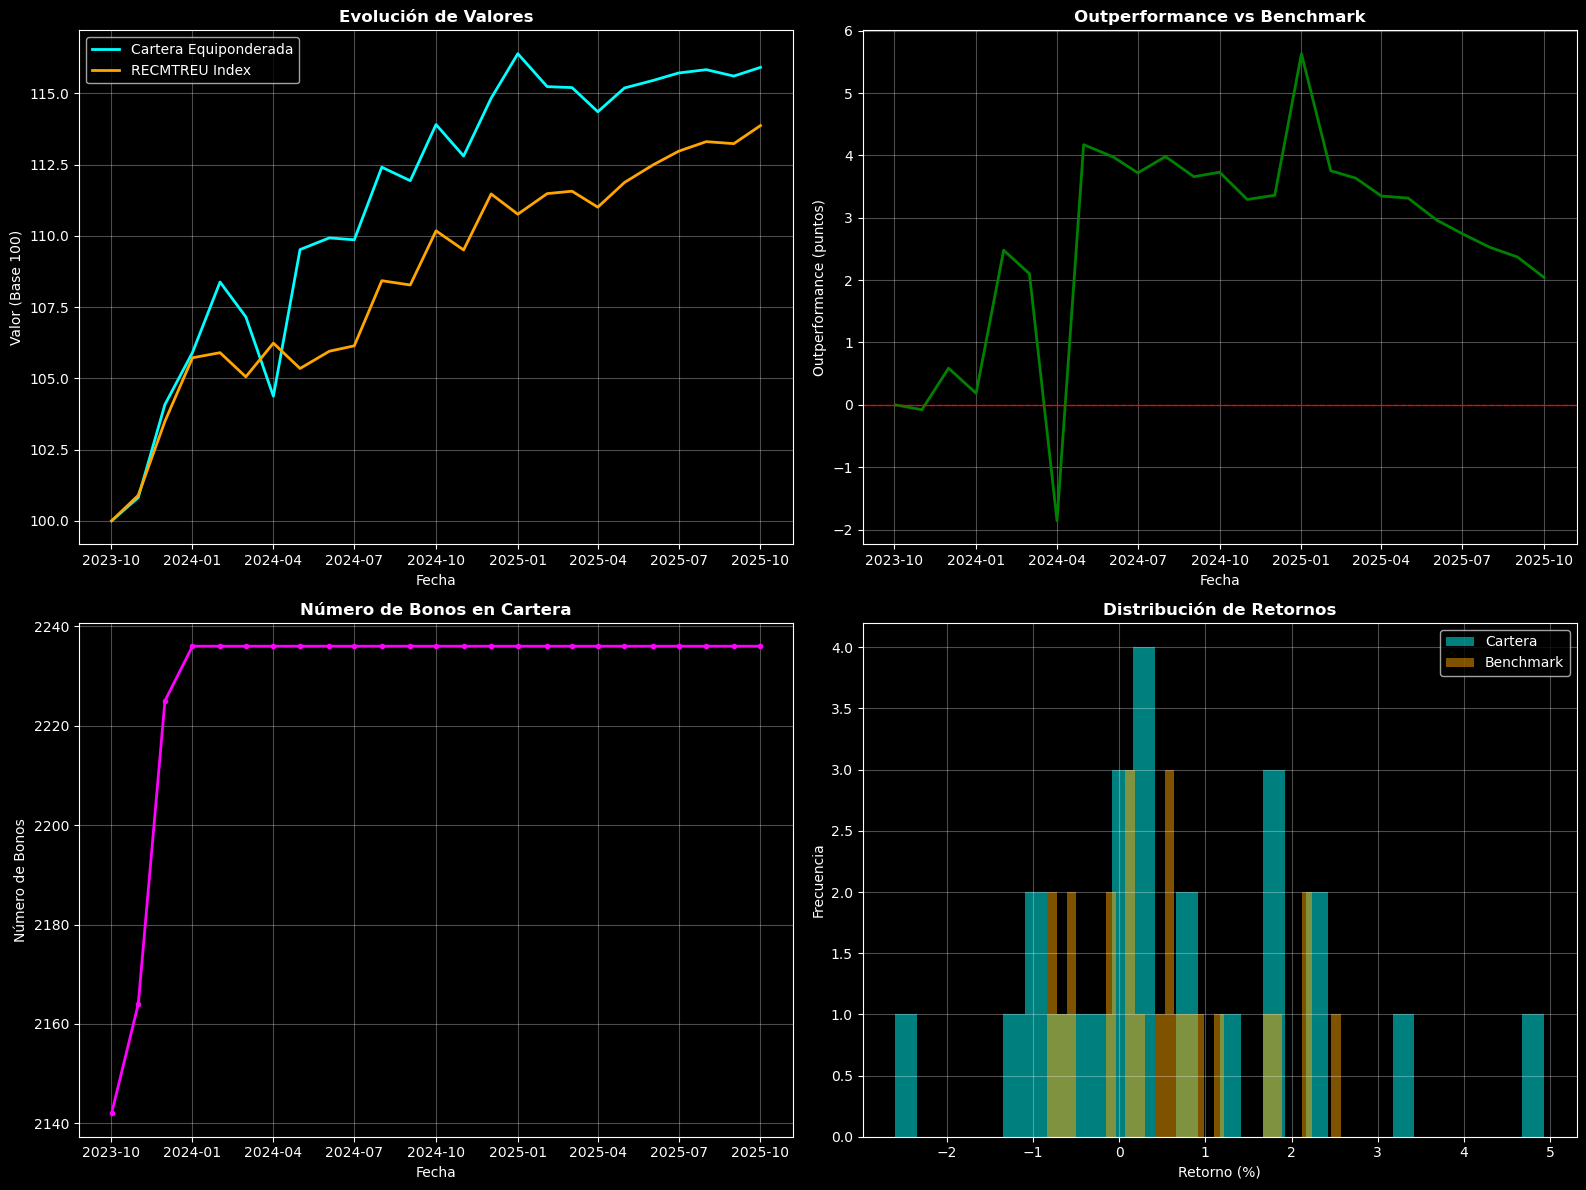

In [ ]:
# ============================================================================
# EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST
# ============================================================================
# Construimos una cartera equiponderada y hacemos backtest comparando con benchmark
# Usamos los precios traspuestos del ejercicio 1 y aplicamos ffill a valores vacíos
# ============================================================================

print("=" * 80)
print("EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST")
print("=" * 80)

# Usar los precios traspuestos del ejercicio 1 (precios_transpuesto)
# Si no existe, crearlo desde precios_universo
if 'precios_transpuesto' not in locals() and 'precios_transpuesto' not in globals():
    print("\n⚠️  Variable 'precios_transpuesto' no encontrada. Creándola desde precios_universo...")
    
    # Cargar precios si no están cargados
    if 'precios_universo' not in locals() and 'precios_universo' not in globals():
        precios_universo = pd.read_csv(
            '../data/precios_historicos_universo.csv',
            sep=';',
            decimal='.',
            na_values=['#N/D', ' ', 'NA', 'nan', 'N/A', '']
        )
    
    # Preparación y transposición (igual que en ejercicio 1)
    precios_df_preparado = precios_universo.rename(
        columns={precios_universo.columns[0]: 'Date'}
    ).set_index('Date')
    
    # Ejecutar la transpuesta (.T)
    precios_transpuesto = precios_df_preparado.T
    
    # Limpieza de fechas
    precios_transpuesto.index = pd.to_datetime(
        precios_transpuesto.index,
        format='%d/%m/%Y',
        errors='coerce'
    )
    
    # Eliminar filas completamente nulas
    precios_transpuesto = precios_transpuesto.dropna(how='all')
    
    print("✓ Precios traspuestos creados desde precios_universo")
else:
    print("\n✓ Usando precios_transpuesto del ejercicio 1")

# Aplicar forward fill (ffill) a los valores vacíos
# ffill rellena hacia adelante usando el último valor válido
print("\nAplicando forward fill (ffill) a valores vacíos...")
precios_historicos_universo = precios_transpuesto.copy()

# Aplicar ffill por columna (a lo largo del tiempo para cada ISIN)
# axis=0 significa rellenar hacia abajo (en el tiempo)
precios_historicos_universo = precios_historicos_universo.ffill(axis=0)

# Si aún quedan valores nulos al principio (antes del primer precio válido),
# podemos usar bfill (backward fill) para rellenar hacia atrás
precios_historicos_universo = precios_historicos_universo.bfill(axis=0)

# Verificar cuántos valores nulos quedan
nulos_antes = precios_transpuesto.isna().sum().sum()
nulos_despues = precios_historicos_universo.isna().sum().sum()
print(f"   Valores nulos antes de ffill: {nulos_antes:,}")
print(f"   Valores nulos después de ffill: {nulos_despues:,}")
print(f"   Valores rellenados: {nulos_antes - nulos_despues:,}")

# Normalizar el índice de fechas (asegurar que no tenga componente de hora)
precios_historicos_universo.index = pd.to_datetime(precios_historicos_universo.index).normalize()

# IMPORTANTE: Limpiar los nombres de las columnas (ISINs) para que coincidan con el universo
# Los precios tienen " Corp" al final, pero el universo no
print("\nLimpiando nombres de columnas (ISINs) para que coincidan con el universo...")
columnas_originales = precios_historicos_universo.columns.tolist()
# Eliminar " Corp" del final de cada nombre de columna
columnas_limpias = [col.replace(' Corp', '') if isinstance(col, str) else col for col in columnas_originales]
precios_historicos_universo.columns = columnas_limpias

print(f"   Ejemplo: '{columnas_originales[0]}' -> '{columnas_limpias[0]}'")

print(f"\nPrecios históricos cargados: {len(precios_historicos_universo)} fechas, {len(precios_historicos_universo.columns)} ISINs")
print(f"Estructura: índice = fechas, columnas = ISINs")
print(f"Primeras fechas: {precios_historicos_universo.index[:5].tolist()}")
print(f"Primeros 5 ISINs en precios: {list(precios_historicos_universo.columns[:5])}")
print(f"Primeros 5 ISINs en universo: {list(universo['ISIN'].head()) if 'ISIN' in universo.columns else 'No hay columna ISIN'}")

# Verificar coincidencia de ISINs
if 'ISIN' in universo.columns:
    isins_precios = set(precios_historicos_universo.columns)
    isins_universo = set(universo['ISIN'].dropna())
    isins_comunes = isins_precios.intersection(isins_universo)
    print(f"\n✓ ISINs comunes entre precios y universo: {len(isins_comunes)}")
    print(f"  ISINs solo en precios: {len(isins_precios - isins_universo)}")
    print(f"  ISINs solo en universo: {len(isins_universo - isins_precios)}")

# Cargar benchmark (RECMTREU)
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', 
                             sep=';', decimal='.', 
                             na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])

fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], 
                                           format='%d/%m/%Y', errors='coerce')
precios_varios = precios_varios.set_index(fecha_col)

benchmark_precios = precios_varios[['RECMTREU Index']].copy()

# Fechas de rebalanceo (mensual)
# Usar las fechas disponibles en los precios históricos
fecha_inicio = pd.to_datetime('2023-10-02')
fecha_fin = pd.to_datetime('2025-10-01')

# Obtener fechas disponibles en el rango
fechas_disponibles = precios_historicos_universo.index[
    (precios_historicos_universo.index >= fecha_inicio) & 
    (precios_historicos_universo.index <= fecha_fin)
]

# Seleccionar una fecha por mes (la primera disponible de cada mes)
fechas_rebalanceo = []
mes_actual = None
año_actual = None
for fecha in fechas_disponibles:
    if mes_actual is None or fecha.month != mes_actual or fecha.year != año_actual:
        fechas_rebalanceo.append(fecha)
        mes_actual = fecha.month
        año_actual = fecha.year

# Convertir a DatetimeIndex y normalizar para asegurar formato consistente
fechas_rebalanceo = pd.DatetimeIndex([pd.to_datetime(f).normalize() for f in fechas_rebalanceo])

print(f"Fechas de rebalanceo: {len(fechas_rebalanceo)}")
if len(fechas_rebalanceo) > 0:
    print(f"Rango: {fechas_rebalanceo[0]} a {fechas_rebalanceo[-1]}")
    print(f"Primeras 5 fechas: {fechas_rebalanceo[:5].tolist()}")
else:
    print("No se encontraron fechas disponibles en el rango especificado")

# Función auxiliar para encontrar la fecha más cercana disponible
def encontrar_fecha_cercana(fecha, precios_df):
    """Encuentra la fecha más cercana disponible en el DataFrame de precios."""
    # Normalizar fecha a pd.Timestamp para comparación consistente
    if isinstance(fecha, datetime.date):
        fecha = pd.to_datetime(fecha)
    elif not isinstance(fecha, pd.Timestamp):
        fecha = pd.to_datetime(fecha)
    
    # Normalizar a fecha sin hora para comparar solo fechas
    fecha_normalizada = fecha.normalize() if hasattr(fecha, 'normalize') else fecha
    
    # Normalizar índice del DataFrame también
    try:
        indice_normalizado = precios_df.index.normalize()
    except:
        indice_normalizado = precios_df.index
    
    # Buscar fecha exacta
    if fecha_normalizada in indice_normalizado:
        idx_pos = indice_normalizado.get_loc(fecha_normalizada)
        return precios_df.index[idx_pos]
    
    # Buscar la fecha más cercana anterior
    fechas_disponibles = indice_normalizado[indice_normalizado <= fecha_normalizada]
    if len(fechas_disponibles) > 0:
        fecha_encontrada = fechas_disponibles[-1]
        idx_pos = indice_normalizado.get_loc(fecha_encontrada)
        return precios_df.index[idx_pos]
    
    return None

# Función para obtener bonos vivos en una fecha
def obtener_bonos_vivos(fecha, universo_df, precios_df):
    """Obtiene los bonos vivos (disponibles) en una fecha dada."""
    # Convertir fecha a datetime si es date
    if isinstance(fecha, datetime.date):
        fecha = pd.to_datetime(fecha)
    
    # Encontrar fecha más cercana disponible
    fecha_disponible = encontrar_fecha_cercana(fecha, precios_df)
    if fecha_disponible is None:
        return pd.DataFrame()
    
    # Filtrar bonos emitidos antes de la fecha
    bonos_emitidos = universo_df[
        pd.to_datetime(universo_df.get('Issue date', pd.NaT), errors='coerce') <= fecha
    ]
    
    # Filtrar bonos que no han vencido
    bonos_vivos = bonos_emitidos[
        pd.to_datetime(bonos_emitidos.get('Maturity', pd.NaT), errors='coerce') > fecha
    ]
    
    # Filtrar bonos con precio disponible en la fecha más cercana
    if fecha_disponible in precios_df.index:
        precios_fecha = precios_df.loc[fecha_disponible]
        # Obtener ISINs con precio válido (no nulo y > 0)
        # Después del ffill, algunos valores pueden seguir siendo nulos si no había valores previos
        isins_con_precio = precios_fecha[
            precios_fecha.notna() & 
            (precios_fecha > 0) & 
            (precios_fecha < 1000)  # Filtrar valores anómalos (precios muy altos)
        ].index.tolist()
        
        # Convertir a string para asegurar coincidencia
        isins_con_precio = [str(isin) for isin in isins_con_precio]
        bonos_vivos = bonos_vivos[bonos_vivos['ISIN'].isin(isins_con_precio)]
    
    return bonos_vivos

# Función para calcular rentabilidad total
def calcular_rentabilidad_total(fecha_anterior, fecha_actual, isins, pesos, precios_df):
    """Calcula la rentabilidad total de la cartera entre dos fechas."""
    rentabilidad_total = 0.0
    
    # Encontrar fechas más cercanas disponibles
    fecha_ant_disponible = encontrar_fecha_cercana(fecha_anterior, precios_df)
    fecha_act_disponible = encontrar_fecha_cercana(fecha_actual, precios_df)
    
    if fecha_ant_disponible is None or fecha_act_disponible is None:
        return 0.0
    
    for isin, peso in zip(isins, pesos):
        # Convertir ISIN a string para asegurar coincidencia
        isin_str = str(isin)
        
        if isin_str not in precios_df.columns:
            continue
        
        try:
            precio_anterior = precios_df.loc[fecha_ant_disponible, isin_str]
            precio_actual = precios_df.loc[fecha_act_disponible, isin_str]
            
            # Verificar que ambos precios sean válidos (no nulos, > 0, y razonables)
            if (pd.notna(precio_anterior) and pd.notna(precio_actual) and 
                precio_anterior > 0 and precio_actual > 0 and
                precio_anterior < 1000 and precio_actual < 1000):  # Filtrar valores anómalos
                retorno = (precio_actual - precio_anterior) / precio_anterior
                rentabilidad_total += peso * retorno
        except (KeyError, IndexError, TypeError):
            continue
    
    return rentabilidad_total

# Ejecutar backtest
print("\n" + "=" * 80)
print("EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA")
print("=" * 80)

if len(fechas_rebalanceo) == 0:
    print("ERROR: No hay fechas disponibles para el backtest")
    print("Verifica que los precios históricos contengan datos en el rango especificado")
else:
    resultados_backtest = []
    valor_cartera = 100.0  # Valor inicial = 100
    valor_benchmark = 100.0

    # Información de depuración
    print(f"\nIniciando backtest con {len(fechas_rebalanceo)} fechas de rebalanceo...")
    
    for i, fecha in enumerate(fechas_rebalanceo):
        # Obtener bonos vivos
        bonos_vivos = obtener_bonos_vivos(fecha, universo, precios_historicos_universo)
        
        n_bonos = len(bonos_vivos)
        
        # Información de depuración para las primeras iteraciones
        if i < 3:
            print(f"\nFecha {i+1}/{len(fechas_rebalanceo)}: {fecha.date()}")
            print(f"  Bonos vivos encontrados: {n_bonos}")
            if n_bonos > 0:
                print(f"  Primeros 3 ISINs: {bonos_vivos['ISIN'].head(3).tolist()}")
        
        # Calcular rentabilidad de la cartera solo si hay bonos vivos
        if n_bonos > 0 and i > 0:
            # Peso equiponderado
            peso_por_bono = 1.0 / n_bonos
            isins = bonos_vivos['ISIN'].tolist()
            pesos = [peso_por_bono] * n_bonos
            
            # Calcular rentabilidad desde fecha anterior
            fecha_anterior = fechas_rebalanceo[i-1]
            retorno_cartera = calcular_rentabilidad_total(
                fecha_anterior, fecha, isins, pesos, precios_historicos_universo
            )
            valor_cartera *= (1 + retorno_cartera)
        elif i == 0:
            # Primera fecha: mantener valor inicial
            pass
        elif n_bonos == 0:
            # No hay bonos vivos: mantener el valor anterior (sin cambios)
            pass
        
        # Calcular rentabilidad benchmark (siempre, para tener la comparativa completa)
        if i > 0:
            fecha_anterior = fechas_rebalanceo[i-1]
            # Rentabilidad benchmark (usar fechas más cercanas disponibles)
            fecha_ant_bench = encontrar_fecha_cercana(fecha_anterior, benchmark_precios)
            fecha_act_bench = encontrar_fecha_cercana(fecha, benchmark_precios)
            
            if fecha_ant_bench is not None and fecha_act_bench is not None:
                try:
                    precio_bench_anterior = benchmark_precios.loc[fecha_ant_bench, 'RECMTREU Index']
                    precio_bench_actual = benchmark_precios.loc[fecha_act_bench, 'RECMTREU Index']
                    if pd.notna(precio_bench_anterior) and pd.notna(precio_bench_actual) and precio_bench_anterior > 0:
                        retorno_bench = (precio_bench_actual - precio_bench_anterior) / precio_bench_anterior
                        valor_benchmark *= (1 + retorno_bench)
                except (KeyError, IndexError):
                    pass
        
        resultados_backtest.append({
            'Fecha': fecha,
            'N_Bonos': n_bonos,
            'Valor_Cartera': valor_cartera,
            'Valor_Benchmark': valor_benchmark,
            'Outperformance': valor_cartera - valor_benchmark
        })

    df_backtest = pd.DataFrame(resultados_backtest)
    if len(df_backtest) > 0:
        df_backtest = df_backtest.set_index('Fecha')

        print(f"\nResultados del backtest:")
        print(df_backtest.tail(10))

        # Calcular métricas de performance
        retornos_cartera = df_backtest['Valor_Cartera'].pct_change().dropna()
        retornos_bench = df_backtest['Valor_Benchmark'].pct_change().dropna()

        rentabilidad_total_cartera = (df_backtest['Valor_Cartera'].iloc[-1] / 
                                     df_backtest['Valor_Cartera'].iloc[0] - 1) * 100
        rentabilidad_total_bench = (df_backtest['Valor_Benchmark'].iloc[-1] / 
                                   df_backtest['Valor_Benchmark'].iloc[0] - 1) * 100

        volatilidad_cartera = retornos_cartera.std() * np.sqrt(252) * 100
        volatilidad_bench = retornos_bench.std() * np.sqrt(252) * 100

        excess_returns = retornos_cartera - retornos_bench
        tracking_error = excess_returns.std() * np.sqrt(252) * 100
        information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() > 0 else 0

        print("\n" + "=" * 80)
        print("MÉTRICAS DE PERFORMANCE")
        print("=" * 80)
        print(f"Rentabilidad Total Cartera: {rentabilidad_total_cartera:.2f}%")
        print(f"Rentabilidad Total Benchmark: {rentabilidad_total_bench:.2f}%")
        print(f"Outperformance: {rentabilidad_total_cartera - rentabilidad_total_bench:.2f}%")
        print(f"Volatilidad Cartera: {volatilidad_cartera:.2f}%")
        print(f"Volatilidad Benchmark: {volatilidad_bench:.2f}%")
        print(f"Tracking Error: {tracking_error:.2f}%")
        print(f"Information Ratio: {information_ratio:.4f}")

        # Visualización
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Evolución de valores
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Cartera'], 
                        label='Cartera Equiponderada', linewidth=2, color='cyan')
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Benchmark'], 
                        label='RECMTREU Index', linewidth=2, color='orange')
        axes[0, 0].set_title('Evolución de Valores', fontweight='bold')
        axes[0, 0].set_xlabel('Fecha')
        axes[0, 0].set_ylabel('Valor (Base 100)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Outperformance
        axes[0, 1].plot(df_backtest.index, df_backtest['Outperformance'], 
                        linewidth=2, color='green')
        axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
        axes[0, 1].set_title('Outperformance vs Benchmark', fontweight='bold')
        axes[0, 1].set_xlabel('Fecha')
        axes[0, 1].set_ylabel('Outperformance (puntos)')
        axes[0, 1].grid(True, alpha=0.3)

        # Número de bonos en cartera
        axes[1, 0].plot(df_backtest.index, df_backtest['N_Bonos'], 
                        linewidth=2, color='magenta', marker='o', markersize=3)
        axes[1, 0].set_title('Número de Bonos en Cartera', fontweight='bold')
        axes[1, 0].set_xlabel('Fecha')
        axes[1, 0].set_ylabel('Número de Bonos')
        axes[1, 0].grid(True, alpha=0.3)

        # Distribución de retornos
        axes[1, 1].hist(retornos_cartera * 100, bins=30, alpha=0.5, label='Cartera', color='cyan')
        axes[1, 1].hist(retornos_bench * 100, bins=30, alpha=0.5, label='Benchmark', color='orange')
        axes[1, 1].set_title('Distribución de Retornos', fontweight='bold')
        axes[1, 1].set_xlabel('Retorno (%)')
        axes[1, 1].set_ylabel('Frecuencia')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()



    else:
        print("No se generaron resultados del backtest")


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

EJERCICIO 6: CARTERA CON MANDATO - MAXIMIZANDO YTM

1. Aplicando filtros iniciales...
   Bonos elegibles tras filtros: 1353

2. Calculando YTM y Duración para cada bono...
   (Esto puede tardar unos segundos...)
   Bonos con métricas válidas: 1353

3. Clasificando ratings...
   Bonos con rating válido: 1204
   - Investment Grade: 1199
   - High Yield: 5

4. Preseleccionando candidatos para optimización...
   Pool de candidatos para optimización: 109 bonos

5. Optimizando cartera para maximizar YTM...
   Ejecutando optimización (método SLSQP)...

6. Resultados de la optimización...

CARTERA ÓPTIMA GENERADA - MAXIMIZANDO YTM

✓ Número de bonos:           10 / 20 (máximo)
✓ YTM de la cartera:         8.00%
✓ Duración ponderada:       0.94 años (máx 3.0)
✓ Exposición High Yield:     0.00% (máx 10%)
✓ Máximo peso por emisión:   10.00% (máx 10%)
✓ Máximo peso por emisor:    10.00% (máx 15%)
✓ Número de emisores:        10

---------------------------------------------------------------------

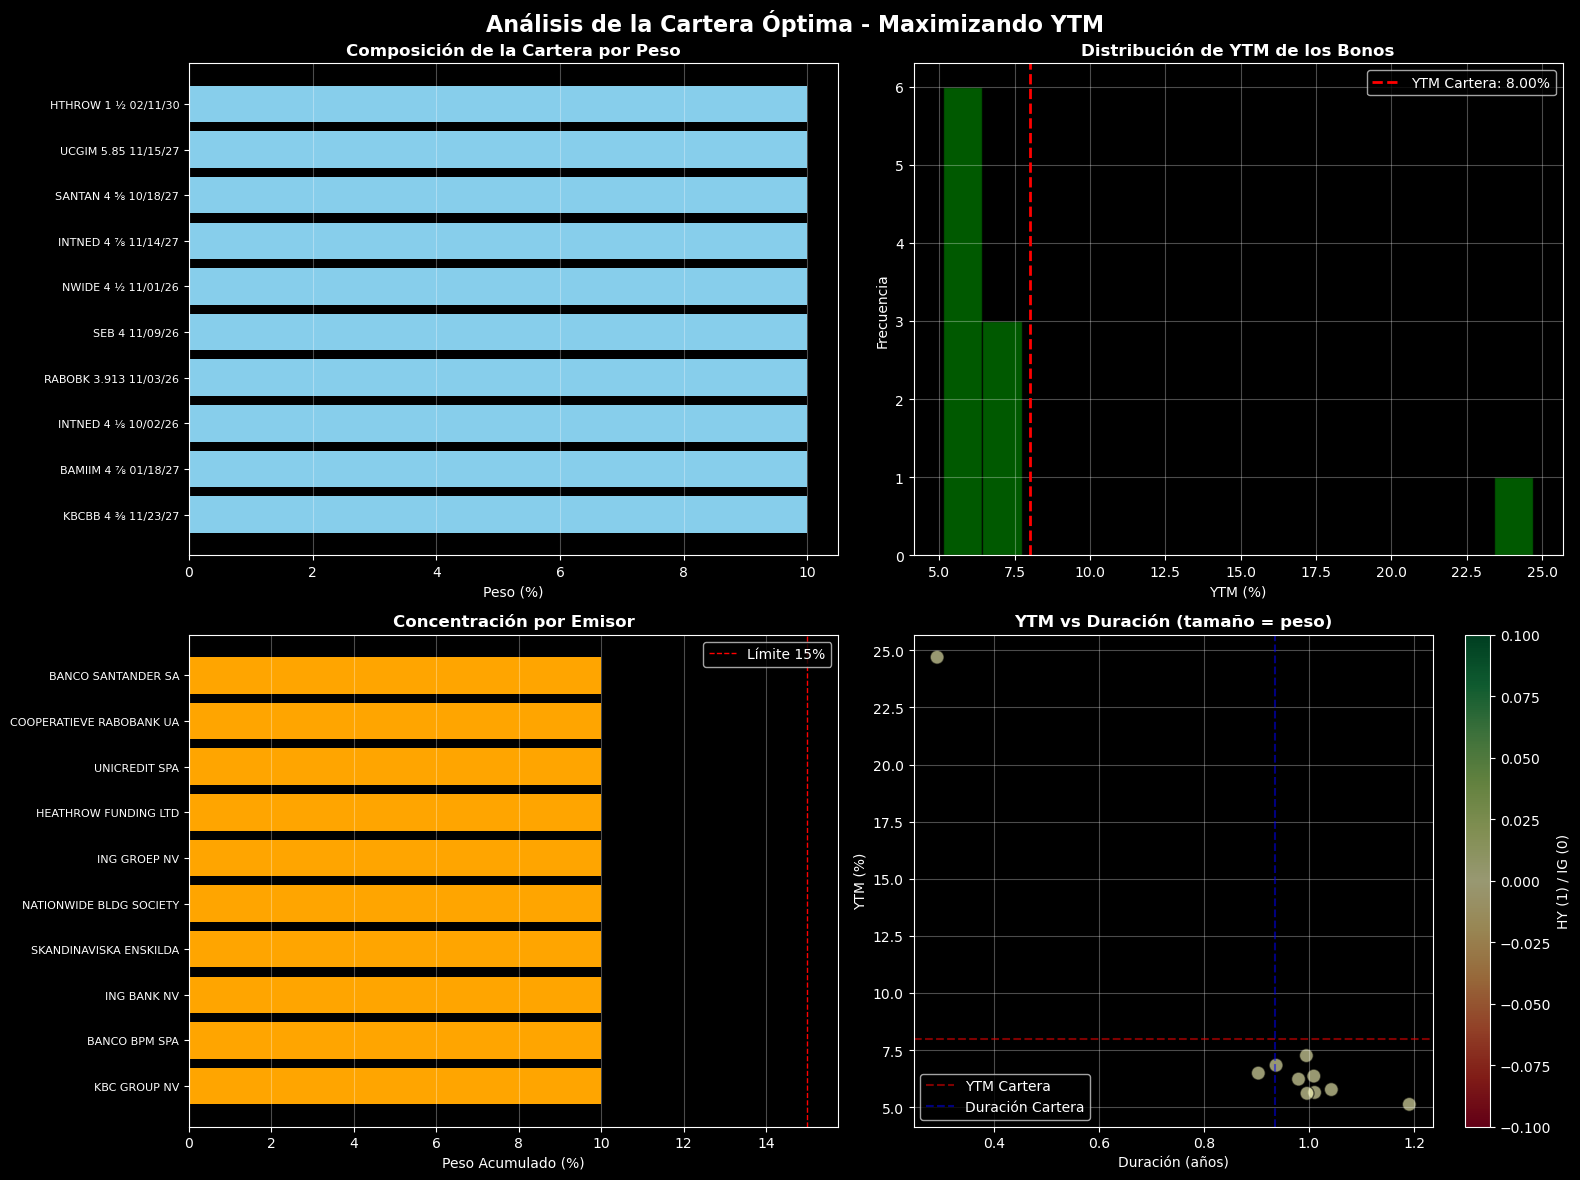


✓ CARTERA CONSTRUIDA EXITOSAMENTE


In [ ]:

# ==============================================================================
# EJERCICIO 6: CONSTRUCCIÓN DE CARTERA CON MANDATO - MAXIMIZANDO YTM
# ==============================================================================
# Objetivo: Construir cartera de máximo 20 bonos que maximice YTM
# Restricciones:
# - Duración <= 3 años
# - Exposición HY <= 10%
# - No deuda subordinada
# - Tamaño emisión > 500M
# - Máximo 10% por emisión
# - Máximo 15% por emisor
# ==============================================================================

from scipy.optimize import minimize, newton
from scipy.optimize import minimize as opt_minimize
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("EJERCICIO 6: CARTERA CON MANDATO - MAXIMIZANDO YTM")
print("=" * 80)

# ==============================================================================
# 1. FILTROS INICIALES (RESTRICCIONES HARD)
# ==============================================================================
print("\n1. Aplicando filtros iniciales...")

# FILTRO 1: Tamaño de emisión > 500 Millones
filtro_tamano = universo['Outstanding Amount'] > 500_000_000

# FILTRO 2: No Deuda Subordinada
filtro_seniority = ~universo['Seniority'].str.contains('Subordinated|Jr', case=False, na=False)

# FILTRO 3: Bonos vivos (no vencidos) y con precio disponible
filtro_vivos = (universo['Maturity'] > fecha_analisis) & (universo['Price'].notna())

# Aplicar todos los filtros
df_eligible = universo[
    filtro_tamano & 
    filtro_seniority & 
    filtro_vivos
].copy()

print(f"   Bonos elegibles tras filtros: {len(df_eligible)}")

# ==============================================================================
# 2. CÁLCULO DE YTM Y DURACIÓN PARA CADA BONO
# ==============================================================================
print("\n2. Calculando YTM y Duración para cada bono...")
print("   (Esto puede tardar unos segundos...)")

# Usar la función calcular_ytm que ya está definida en el notebook
fecha_analisis_dt = pd.to_datetime(fecha_analisis)

def calcular_ytm_y_duracion(row):
    """
    Calcula YTM y Duración Modificada para un bono usando la función calcular_ytm
    que ya está definida en el notebook.
    """
    try:
        precio_mercado = row['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            return np.nan, np.nan
        
        # Calcular YTM usando la función del notebook
        ytm = calcular_ytm(row, precio_mercado, fecha_analisis_dt)
        
        if np.isnan(ytm) or ytm <= 0:
            return np.nan, np.nan
        
        # Calcular Duración Modificada
        duracion_mod = calcular_duracion_modificada(
            calcular_duracion_macaulay(row, fecha_analisis_dt, ytm),
            ytm,
            int(row['Coupon Frequency']) if pd.notna(row['Coupon Frequency']) else 1
        )
        
        return ytm, duracion_mod
    except Exception as e:
        return np.nan, np.nan

# Calcular métricas para todos los bonos elegibles
metricas_list = []
for idx, bono in df_eligible.iterrows():
    ytm, dur = calcular_ytm_y_duracion(bono)
    metricas_list.append({'YTM': ytm, 'Duration': dur})

df_metricas = pd.DataFrame(metricas_list)
df_eligible['YTM'] = df_metricas['YTM'].values
df_eligible['Duration'] = df_metricas['Duration'].values

# Eliminar bonos sin métricas válidas
df_eligible = df_eligible.dropna(subset=['YTM', 'Duration'])
df_eligible = df_eligible[(df_eligible['YTM'] > 0) & (df_eligible['Duration'] > 0)]

print(f"   Bonos con métricas válidas: {len(df_eligible)}")

# ==============================================================================
# 3. CLASIFICACIÓN DE RATINGS (IG vs HY)
# ==============================================================================
print("\n3. Clasificando ratings...")

# Definir ratings Investment Grade y High Yield
investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']

def clasificar_rating(rating):
    if pd.isna(rating) or str(rating).strip() == 'NR':
        return 'NR'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'IG'
    elif rating_clean in high_yield:
        return 'HY'
    else:
        return 'NR'

df_eligible['Rating_Class'] = df_eligible['Rating'].apply(clasificar_rating)
df_eligible['Is_HY'] = (df_eligible['Rating_Class'] == 'HY').astype(int)

# Eliminar bonos sin rating (NR) ya que no podemos clasificarlos
df_eligible = df_eligible[df_eligible['Rating_Class'] != 'NR']

print(f"   Bonos con rating válido: {len(df_eligible)}")
print(f"   - Investment Grade: {len(df_eligible[df_eligible['Rating_Class'] == 'IG'])}")
print(f"   - High Yield: {len(df_eligible[df_eligible['Rating_Class'] == 'HY'])}")

# ==============================================================================
# 4. PRESELECCIÓN DE CANDIDATOS PARA OPTIMIZACIÓN
# ==============================================================================
print("\n4. Preseleccionando candidatos para optimización...")

# Estrategia: Seleccionar top candidatos por YTM y algunos de baja duración
# para asegurar que podemos cumplir la restricción de duración <= 3 años

# Top 100 por YTM
candidatos_ytm = df_eligible.nlargest(100, 'YTM')

# Top 50 de baja duración (< 2.5 años) con buen YTM
candidatos_duracion = df_eligible[df_eligible['Duration'] < 2.5].nlargest(50, 'YTM')

# Combinar y eliminar duplicados
pool = pd.concat([candidatos_ytm, candidatos_duracion]).drop_duplicates(subset=['ISIN']).reset_index(drop=True)

print(f"   Pool de candidatos para optimización: {len(pool)} bonos")

# ==============================================================================
# 5. OPTIMIZACIÓN: MAXIMIZAR YTM CON RESTRICCIONES
# ==============================================================================
print("\n5. Optimizando cartera para maximizar YTM...")

n = len(pool)
ytm_values = pool['YTM'].values
dur_values = pool['Duration'].values
is_hy_values = pool['Is_HY'].values

# Crear matriz de emisores para restricción de concentración
emisores = pool['Issuer'].values
emisores_unicos = pd.unique(emisores)
matriz_emisores = np.array([(emisores == emisor).astype(float) for emisor in emisores_unicos]).T

# Función objetivo: MAXIMIZAR YTM (minimizar -YTM)
def objetivo(w):
    return -np.dot(w, ytm_values)

# Restricciones
constraints = []

# Restricción 1: Suma de pesos = 1 (100% invertido)
constraints.append({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1.0
})

# Restricción 2: Duración ponderada <= 3 años
constraints.append({
    'type': 'ineq',
    'fun': lambda w: 3.0 - np.dot(w, dur_values)
})

# Restricción 3: Exposición HY <= 10%
constraints.append({
    'type': 'ineq',
    'fun': lambda w: 0.10 - np.dot(w, is_hy_values)
})

# Restricción 4: Máximo 15% por emisor
for i in range(len(emisores_unicos)):
    emisor_col = matriz_emisores[:, i]
    constraints.append({
        'type': 'ineq',
        'fun': lambda w, col=emisor_col: 0.15 - np.dot(w, col)
    })

# Restricción 5: Máximo 20 bonos (usando penalización L0 aproximada)
# Usaremos una aproximación: penalizar si hay más de 20 pesos > umbral
def restriccion_max_bonos(w):
    # Contar bonos con peso > 0.001 (0.1%)
    num_bonos = np.sum(w > 0.001)
    # Penalizar si hay más de 20
    return 20.0 - num_bonos

constraints.append({
    'type': 'ineq',
    'fun': restriccion_max_bonos
})

# Bounds: cada bono entre 0% y 10% (máximo 10% por emisión)
bounds = [(0.0, 0.10) for _ in range(n)]

# Punto inicial: distribución equiponderada entre los top 20 por YTM
top_20_idx = np.argsort(ytm_values)[-20:][::-1]
x0 = np.zeros(n)
x0[top_20_idx] = 1.0 / 20.0

# Ejecutar optimización
print("   Ejecutando optimización (método SLSQP)...")
resultado = opt_minimize(
    objetivo,
    x0=x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-6}
)

# ==============================================================================
# 6. RESULTADOS Y VERIFICACIÓN
# ==============================================================================
print("\n6. Resultados de la optimización...")

if resultado.success:
    pesos = resultado.x
    pool['Weight'] = pesos
    
    # Filtrar bonos con peso significativo (> 0.1%)
    cartera = pool[pool['Weight'] > 0.001].copy()
    cartera = cartera.sort_values('Weight', ascending=False)
    
    # Calcular métricas de la cartera
    ytm_cartera = np.dot(cartera['Weight'], cartera['YTM'])
    duracion_cartera = np.dot(cartera['Weight'], cartera['Duration'])
    peso_hy = np.dot(cartera['Weight'], cartera['Is_HY'])
    
    # Verificar restricciones
    peso_por_emisor = cartera.groupby('Issuer')['Weight'].sum()
    max_peso_emisor = peso_por_emisor.max() if len(peso_por_emisor) > 0 else 0.0
    max_peso_emision = cartera['Weight'].max()
    
    print("\n" + "=" * 80)
    print("CARTERA ÓPTIMA GENERADA - MAXIMIZANDO YTM")
    print("=" * 80)
    print(f"\n✓ Número de bonos:           {len(cartera)} / 20 (máximo)")
    print(f"✓ YTM de la cartera:         {ytm_cartera*100:.2f}%")
    print(f"✓ Duración ponderada:       {duracion_cartera:.2f} años (máx 3.0)")
    print(f"✓ Exposición High Yield:     {peso_hy*100:.2f}% (máx 10%)")
    print(f"✓ Máximo peso por emisión:   {max_peso_emision*100:.2f}% (máx 10%)")
    print(f"✓ Máximo peso por emisor:    {max_peso_emisor*100:.2f}% (máx 15%)")
    print(f"✓ Número de emisores:        {cartera['Issuer'].nunique()}")
    
    # Verificación de restricciones
    print("\n" + "-" * 80)
    print("VERIFICACIÓN DE RESTRICCIONES:")
    print("-" * 80)
    print(f"✓ Duración <= 3 años:        {'✓ CUMPLE' if duracion_cartera <= 3.0 else '✗ NO CUMPLE'}")
    print(f"✓ HY <= 10%:                 {'✓ CUMPLE' if peso_hy <= 0.10 else '✗ NO CUMPLE'}")
    print(f"✓ Bonos <= 20:                {'✓ CUMPLE' if len(cartera) <= 20 else '✗ NO CUMPLE'}")
    print(f"✓ Peso emisión <= 10%:       {'✓ CUMPLE' if max_peso_emision <= 0.10 else '✗ NO CUMPLE'}")
    print(f"✓ Peso emisor <= 15%:        {'✓ CUMPLE' if max_peso_emisor <= 0.15 else '✗ NO CUMPLE'}")
    
    # Mostrar tabla detallada de la cartera
    print("\n" + "-" * 80)
    print("COMPOSICIÓN DE LA CARTERA:")
    print("-" * 80)
    
    display_cols = ['ISIN', 'Description', 'Issuer', 'Rating', 'YTM', 'Duration', 'Weight', 'Is_HY']
    display_df = cartera[display_cols].copy()
    display_df['YTM'] = (display_df['YTM'] * 100).round(2)
    display_df['Duration'] = display_df['Duration'].round(2)
    display_df['Weight'] = (display_df['Weight'] * 100).round(2)
    display_df['Is_HY'] = display_df['Is_HY'].map({1: 'HY', 0: 'IG'})
    display_df.columns = ['ISIN', 'Descripción', 'Emisor', 'Rating', 'YTM (%)', 'Duración', 'Peso (%)', 'Tipo']
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    print(display_df.to_string(index=False))
    
    # Gráficos
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis de la Cartera Óptima - Maximizando YTM', fontsize=16, fontweight='bold')
    
    # 1. Composición por peso
    axes[0, 0].barh(range(len(cartera)), cartera['Weight']*100, color='skyblue')
    axes[0, 0].set_yticks(range(len(cartera)))
    axes[0, 0].set_yticklabels(cartera['Description'].str[:30], fontsize=8)
    axes[0, 0].set_xlabel('Peso (%)')
    axes[0, 0].set_title('Composición de la Cartera por Peso', fontweight='bold')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Distribución YTM
    axes[0, 1].hist(cartera['YTM']*100, bins=15, color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(ytm_cartera*100, color='red', linestyle='--', linewidth=2, label=f'YTM Cartera: {ytm_cartera*100:.2f}%')
    axes[0, 1].set_xlabel('YTM (%)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de YTM de los Bonos', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Distribución por emisor
    peso_emisor = cartera.groupby('Issuer')['Weight'].sum().sort_values(ascending=False)
    axes[1, 0].barh(range(len(peso_emisor)), peso_emisor.values*100, color='orange')
    axes[1, 0].set_yticks(range(len(peso_emisor)))
    axes[1, 0].set_yticklabels(peso_emisor.index.str[:25], fontsize=8)
    axes[1, 0].set_xlabel('Peso Acumulado (%)')
    axes[1, 0].set_title('Concentración por Emisor', fontweight='bold')
    axes[1, 0].axvline(15, color='red', linestyle='--', linewidth=1, label='Límite 15%')
    axes[1, 0].invert_yaxis()
    axes[1, 0].legend()
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 4. YTM vs Duración
    scatter = axes[1, 1].scatter(cartera['Duration'], cartera['YTM']*100, 
                                  s=cartera['Weight']*1000, alpha=0.6, 
                                  c=cartera['Is_HY'], cmap='RdYlGn', edgecolors='black')
    axes[1, 1].axhline(ytm_cartera*100, color='red', linestyle='--', alpha=0.5, label=f'YTM Cartera')
    axes[1, 1].axvline(duracion_cartera, color='blue', linestyle='--', alpha=0.5, label=f'Duración Cartera')
    axes[1, 1].set_xlabel('Duración (años)')
    axes[1, 1].set_ylabel('YTM (%)')
    axes[1, 1].set_title('YTM vs Duración (tamaño = peso)', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='HY (1) / IG (0)')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("✓ CARTERA CONSTRUIDA EXITOSAMENTE")
    print("=" * 80)
    
else:
    print(f"\n✗ Error en la optimización: {resultado.message}")
    print("   Intentando con método alternativo...")
    
    # Método alternativo: greedy con verificación de restricciones
    print("\n   Usando algoritmo greedy como alternativa...")
    
    cartera_greedy = []
    pesos_greedy = []
    duracion_acum = 0.0
    peso_hy_acum = 0.0
    peso_por_emisor_greedy = {}
    
    # Ordenar por YTM descendente
    df_sorted = df_eligible.sort_values('YTM', ascending=False)
    
    for idx, bono in df_sorted.iterrows():
        if len(cartera_greedy) >= 20:
            break
        
        peso_tentativo = 0.10  # Máximo permitido por emisión
        
        # Verificar restricciones
        duracion_nueva = (duracion_acum * sum(pesos_greedy) + bono['Duration'] * peso_tentativo) / (sum(pesos_greedy) + peso_tentativo) if sum(pesos_greedy) > 0 else bono['Duration']
        
        if duracion_nueva > 3.0:
            continue
        
        if bono['Is_HY'] == 1 and (peso_hy_acum + peso_tentativo) > 0.10:
            continue
        
        emisor = bono['Issuer']
        peso_emisor_actual = peso_por_emisor_greedy.get(emisor, 0.0)
        if peso_emisor_actual + peso_tentativo > 0.15:
            continue
        
        # Añadir a la cartera
        cartera_greedy.append(bono)
        pesos_greedy.append(peso_tentativo)
        duracion_acum = duracion_nueva
        peso_hy_acum += peso_tentativo if bono['Is_HY'] == 1 else 0.0
        peso_por_emisor_greedy[emisor] = peso_emisor_actual + peso_tentativo
    
    # Normalizar pesos
    if sum(pesos_greedy) > 0:
        pesos_greedy = [p / sum(pesos_greedy) for p in pesos_greedy]
        cartera_greedy_df = pd.DataFrame(cartera_greedy)
        cartera_greedy_df['Weight'] = pesos_greedy
        
        print(f"\n   Cartera greedy construida con {len(cartera_greedy_df)} bonos")
        print(f"   YTM: {np.dot(cartera_greedy_df['Weight'], cartera_greedy_df['YTM'])*100:.2f}%")

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>

ANÁLISIS DE VALORACIÓN DE BONOS CORPORATIVOS
Fecha de análisis: 01/10/2025

[1/4] Preparando datos...
✓ Universo preparado: 2255 bonos
✓ Curva ESTR: 33 puntos
✓ Rango de fechas curva: 01/10/2025 - 03/10/2075

[2/4] Valoración inicial (spread = 0)...

APARTADO 2: VALORACIÓN INICIAL (SPREAD = 0 bp)

Bonos válidos para valoración: 2236

Bonos valorados exitosamente: 2236

Estadísticas de la diferencia (Precio Mercado - Precio Teórico):
count    2236.00
mean       -4.63
std         5.18
min       -51.51
25%        -6.12
50%        -3.40
75%        -1.83
max        47.41
Name: Diferencia, dtype: float64

RMSE: 6.95

[3/4] Calculando spreads de crédito...

APARTADO 3: CÁLCULO DE SPREADS DE CRÉDITO
Progreso: 50/2236 bonos procesados
Progreso: 100/2236 bonos procesados
Progreso: 150/2236 bonos procesados
Progreso: 200/2236 bonos procesados
Progreso: 250/2236 bonos procesados
Progreso: 300/2236 bonos procesados
Progreso: 350/2236 bonos procesados
Progreso: 400/2236 bonos procesados
Progreso: 45

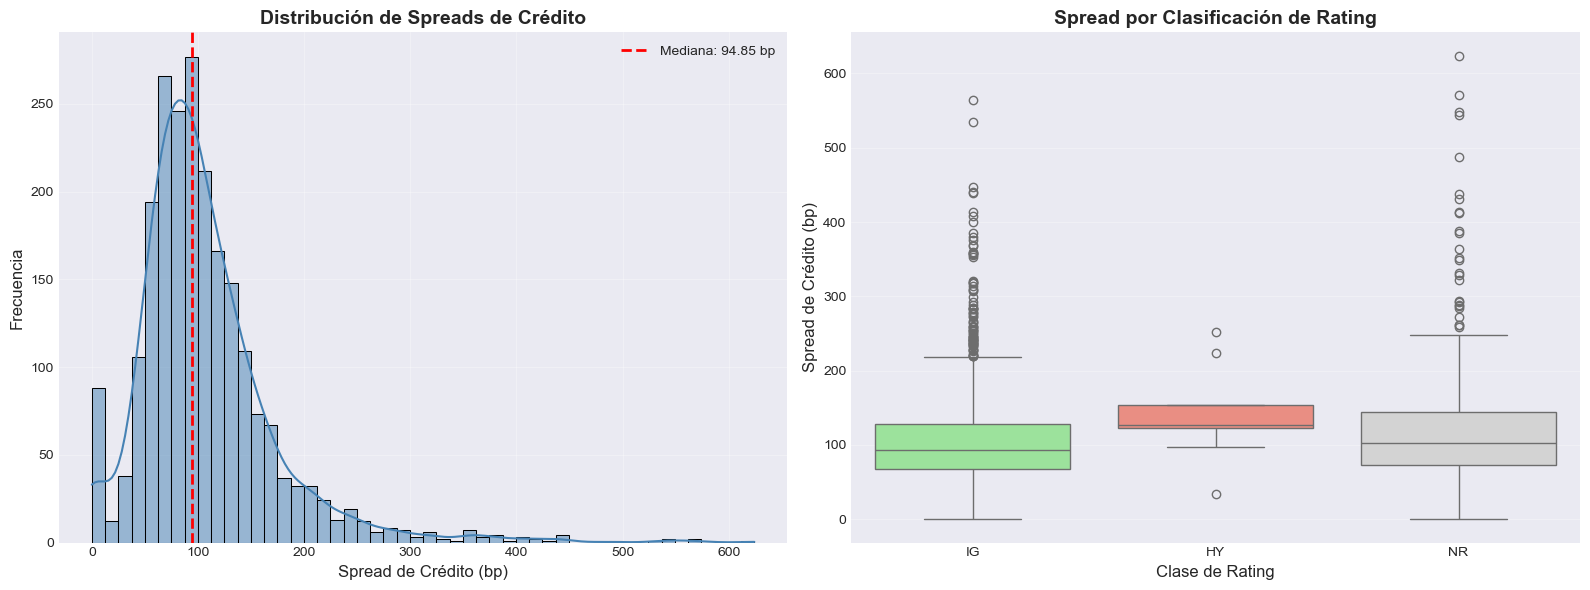


ANÁLISIS COMPLETADO EXITOSAMENTE


In [ ]:
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve, brentq
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURACIÓN Y CONSTANTES
# ==============================================================================

FECHA_ANALISIS = pd.to_datetime('2025-10-01')
INVESTMENT_GRADE_RATINGS = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-'
]

# ==============================================================================
# FUNCIONES DE INTERPOLACIÓN Y VALORACIÓN
# ==============================================================================

def interpolate_discount_factor(curva, fecha_valor, fecha_pago):
    """
    Interpola el factor de descuento usando interpolación log-lineal.
    
    Args:
        curva: DataFrame con la curva de descuento
        fecha_valor: Fecha de valoración
        fecha_pago: Fecha del flujo de caja
        
    Returns:
        Factor de descuento interpolado
    """
    dias_valor = (fecha_pago - fecha_valor).days
    if dias_valor <= 0:
        return 1.0
    
    fechas_curva = curva.index
    factores_curva = curva['Discount'].values
    
    # Filtrar factores válidos
    valid_mask = factores_curva > 0
    if not np.any(valid_mask) or np.sum(valid_mask) < 2:
        return 1.0
    
    factores_validos = factores_curva[valid_mask]
    fechas_validas = fechas_curva[valid_mask]
    
    # Convertir a años
    años_curva = np.array([(f - fecha_valor).days / 365.0 for f in fechas_validas])
    años_pago = dias_valor / 365.0
    
    # Logaritmo de factores para interpolación exponencial
    log_factores = np.log(factores_validos)
    
    # Extrapolación para plazos cortos
    if años_pago <= años_curva[0]:
        if años_curva[0] == 0:
            return 1.0
        return factores_validos[0] ** (años_pago / años_curva[0])
    
    # Extrapolación para plazos largos
    elif años_pago >= años_curva[-1]:
        return factores_validos[-1] ** (años_pago / años_curva[-1])
    
    # Interpolación lineal en espacio logarítmico
    else:
        interp_func = interpolate.interp1d(
            años_curva, log_factores, 
            kind='linear', 
            fill_value='extrapolate'
        )
        log_df = interp_func(años_pago)
        return np.exp(log_df)


def generar_fechas_cupon(bono, fecha_valor):
    """
    Genera todas las fechas de cupón futuras para un bono.
    
    Args:
        bono: Series con información del bono
        fecha_valor: Fecha de valoración
        
    Returns:
        Lista de fechas de cupón futuras
    """
    freq_cupon = bono['Coupon Frequency']
    fecha_vencimiento = bono['Maturity']
    fecha_primer_cupon = bono['First Coupon Date']
    
    # Determinar incremento de fecha según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar próxima fecha de cupón después de fecha_valor
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_valor:
        fecha_actual += offset
    
    # Generar todas las fechas hasta vencimiento
    fechas_cupon = []
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        fecha_actual += offset
    
    # Asegurar que incluye el vencimiento
    if not fechas_cupon or fechas_cupon[-1] != fecha_vencimiento:
        if fecha_vencimiento > fecha_valor:
            fechas_cupon.append(fecha_vencimiento)
    
    return sorted(list(set(fechas_cupon)))


def calcular_cupon_corrido(bono, fecha_valor):
    """
    Calcula el cupón corrido (accrued interest) en la fecha de valoración.
    
    Args:
        bono: Series con información del bono
        fecha_valor: Fecha de valoración
        
    Returns:
        Monto del cupón corrido
    """
    freq_cupon = bono['Coupon Frequency']
    cupon_rate = bono['Coupon']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Determinar offset según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar fecha de cupón anterior
    fecha_temp = bono['First Coupon Date']
    fecha_cupon_anterior = None
    
    while fecha_temp < fecha_valor:
        fecha_cupon_anterior = fecha_temp
        fecha_temp += offset
    
    if fecha_cupon_anterior is None or fecha_cupon_anterior >= fecha_valor:
        return 0.0
    
    # Calcular días transcurridos
    dias_desde_cupon = (fecha_valor - fecha_cupon_anterior).days
    dias_periodo = (fecha_temp - fecha_cupon_anterior).days
    
    if dias_periodo <= 0:
        return 0.0
    
    return cupon_monto_periodico * (dias_desde_cupon / dias_periodo)


def valorar_bono(bono, curva, fecha_valor, spread_credito=0):
    """
    Valora un bono usando descuento de flujos de caja.
    
    Args:
        bono: Series con información del bono
        curva: DataFrame con curva de descuento
        fecha_valor: Fecha de valoración
        spread_credito: Spread de crédito en puntos básicos
        
    Returns:
        Dict con precio_limpio, cupon_corrido y precio_sucio
    """
    # Validar datos esenciales
    if pd.isna(bono['Coupon']) or pd.isna(bono['Coupon Frequency']):
        raise ValueError("Datos de cupón incompletos")
    
    if pd.isna(bono['Maturity']):
        raise ValueError("Fecha de vencimiento no disponible")
    
    fecha_vencimiento = bono['Maturity']
    if fecha_vencimiento <= fecha_valor:
        return {'precio_limpio': 100.0, 'cupon_corrido': 0.0, 'precio_sucio': 100.0}
    
    # Parámetros del bono
    cupon_rate = bono['Coupon']
    freq_cupon = bono['Coupon Frequency']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Generar fechas de pago
    fechas_cupon = generar_fechas_cupon(bono, fecha_valor)
    
    if not fechas_cupon:
        raise ValueError("No se pudieron generar fechas de cupón")
    
    # Valorar flujos de caja
    vp_total = 0.0
    spread_anual = spread_credito / 10000.0
    
    for i, fecha_pago in enumerate(fechas_cupon):
        dias = (fecha_pago - fecha_valor).days
        if dias <= 0:
            continue
        
        # Factor de descuento de la curva
        df = interpolate_discount_factor(curva, fecha_valor, fecha_pago)
        
        # Ajuste por spread de crédito
        t_años = dias / 365.0
        df_ajustado = df * np.exp(-spread_anual * t_años)
        
        # Flujo de caja
        if i == len(fechas_cupon) - 1:  # Último pago
            flujo = cupon_monto_periodico + 100.0  # Cupón + Principal
        else:
            flujo = cupon_monto_periodico
        
        vp_total += flujo * df_ajustado
    
    precio_limpio = vp_total
    cupon_corrido = calcular_cupon_corrido(bono, fecha_valor)
    precio_sucio = precio_limpio + cupon_corrido
    
    return {
        'precio_limpio': precio_limpio,
        'cupon_corrido': cupon_corrido,
        'precio_sucio': precio_sucio
    }


def calcular_spread_credito(bono, curva, fecha_valor, precio_mercado):
    """
    Calcula el spread de crédito implícito usando método de Brent.
    
    Args:
        bono: Series con información del bono
        curva: DataFrame con curva de descuento
        fecha_valor: Fecha de valoración
        precio_mercado: Precio de mercado observado
        
    Returns:
        Spread de crédito en puntos básicos
    """
    def precio_diferencia(spread):
        try:
            valoracion = valorar_bono(bono, curva, fecha_valor, spread_credito=spread)
            return valoracion['precio_limpio'] - precio_mercado
        except:
            return 1e10
    
    try:
        # Usar método de Brent (más robusto que fsolve)
        spread_optimo = brentq(
            precio_diferencia, 
            a=0.0, 
            b=2000.0,  # Máximo 2000 bp
            xtol=0.01,
            maxiter=100
        )
        return max(0.0, spread_optimo)
    except:
        # Si Brent falla, intentar con fsolve
        try:
            spread_optimo = fsolve(precio_diferencia, x0=100.0, xtol=1e-6)[0]
            return max(0.0, spread_optimo)
        except:
            return np.nan


# ==============================================================================
# FUNCIONES DE ANÁLISIS
# ==============================================================================

def clasificar_rating(rating):
    """Clasifica un rating como IG, HY o NR."""
    if pd.isna(rating) or rating == 'NR':
        return 'NR'
    rating_upper = str(rating).strip().upper()
    return 'IG' if rating_upper in INVESTMENT_GRADE_RATINGS else 'HY'


def preparar_datos(universo_df, curva_estr_df):
    """
    Prepara los datos ya cargados en memoria.
    
    Args:
        universo_df: DataFrame con el universo de bonos ya cargado
        curva_estr_df: DataFrame con la curva ESTR (con columnas 'Date' y 'Discount' o similar)
        
    Returns:
        Tuple con universo preparado y curva filtrada
    """
    # Trabajar con una copia para no modificar el original
    universo = universo_df.copy()
    
    # Convertir fechas si no están ya en formato datetime
    campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 
                    'Penultimate Coupon Date', 'Issue date']
    for campo in campos_fecha:
        if campo in universo.columns:
            if not pd.api.types.is_datetime64_any_dtype(universo[campo]):
                universo[campo] = pd.to_datetime(
                    universo[campo].replace('', pd.NA), 
                    format='%d/%m/%Y', 
                    errors='coerce'
                )
    
    # Preparar curva ESTR
    curva_estr = curva_estr_df.copy()
    
    # Detectar la estructura del DataFrame de la curva
    # Caso 1: 'Date' y 'Discount' ya son columnas
    if 'Date' in curva_estr.columns and 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr['Date']):
            curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
        curva_estr.set_index('Date', inplace=True)
    
    # Caso 2: 'Date' es el índice y 'Discount' es columna
    elif 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            curva_estr.index = pd.to_datetime(curva_estr.index, format='%d/%m/%Y', errors='coerce')
    
    # Caso 3: Las columnas tienen nombres diferentes, buscar patrones
    else:
        # Buscar columna de fechas (primera columna generalmente)
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            primera_col = curva_estr.columns[0]
            curva_estr[primera_col] = pd.to_datetime(curva_estr[primera_col], errors='coerce')
            curva_estr.set_index(primera_col, inplace=True)
        
        # Buscar columna de discount (buscar por nombre similar)
        discount_cols = [col for col in curva_estr.columns if 'discount' in col.lower()]
        if discount_cols:
            curva_estr = curva_estr.rename(columns={discount_cols[0]: 'Discount'})
        else:
            # Asumir que la primera columna numérica es el discount
            numeric_cols = curva_estr.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                curva_estr = curva_estr.rename(columns={numeric_cols[0]: 'Discount'})
    
    # Asegurar que tenemos la columna Discount
    if 'Discount' not in curva_estr.columns:
        raise ValueError("No se pudo identificar la columna 'Discount' en la curva ESTR")
    
    # Filtrar curva para fechas futuras y eliminar nulos
    curva_fecha = curva_estr.loc[curva_estr.index >= FECHA_ANALISIS].copy()
    curva_fecha = curva_fecha.dropna(subset=['Discount'])
    
    # Verificar que tenemos datos válidos
    if len(curva_fecha) == 0:
        raise ValueError(f"No hay datos de curva ESTR para fechas >= {FECHA_ANALISIS}")
    
    return universo, curva_fecha


def realizar_valoracion_inicial(universo, curva_fecha):
    """Realiza la valoración inicial con spread = 0."""
    print("\n" + "=" * 80)
    print("APARTADO 2: VALORACIÓN INICIAL (SPREAD = 0 bp)")
    print("=" * 80)
    
    # Filtrar bonos válidos
    bonos_validos = universo[
        universo['Price'].notna() & 
        universo['Coupon'].notna() &
        universo['Coupon Frequency'].notna() & 
        universo['Maturity'].notna() &
        (universo['Maturity'] > FECHA_ANALISIS)
    ].copy()
    
    print(f"\nBonos válidos para valoración: {len(bonos_validos)}")
    
    # Valorar cada bono
    resultados = []
    for idx, bono in bonos_validos.iterrows():
        try:
            valoracion = valorar_bono(bono, curva_fecha, FECHA_ANALISIS, spread_credito=0)
            
            if valoracion['precio_limpio'] > 0:
                precio_mercado = bono['Price']
                precio_teorico = valoracion['precio_limpio']
                
                resultados.append({
                    'ISIN': bono['ISIN'],
                    'Rating': bono['Rating'],
                    'Precio_Mercado': precio_mercado,
                    'Precio_Teorico': precio_teorico,
                    'Diferencia': precio_mercado - precio_teorico,
                    'Diferencia_%': ((precio_mercado - precio_teorico) / precio_teorico) * 100
                })
        except Exception as e:
            continue
    
    df_valoracion = pd.DataFrame(resultados)
    
    # Estadísticas
    print(f"\nBonos valorados exitosamente: {len(df_valoracion)}")
    print("\nEstadísticas de la diferencia (Precio Mercado - Precio Teórico):")
    print(df_valoracion['Diferencia'].describe().round(2))
    print(f"\nRMSE: {np.sqrt((df_valoracion['Diferencia']**2).mean()):.2f}")
    
    return df_valoracion


def calcular_spreads(df_valoracion, universo, curva_fecha):
    """Calcula los spreads de crédito implícitos."""
    print("\n" + "=" * 80)
    print("APARTADO 3: CÁLCULO DE SPREADS DE CRÉDITO")
    print("=" * 80)
    
    spreads = []
    total = len(df_valoracion)
    
    for idx, row in df_valoracion.iterrows():
        bono = universo[universo['ISIN'] == row['ISIN']].iloc[0]
        
        try:
            spread = calcular_spread_credito(
                bono, 
                curva_fecha, 
                FECHA_ANALISIS, 
                row['Precio_Mercado']
            )
            spreads.append(spread)
        except:
            spreads.append(np.nan)
        
        # Progreso
        if (idx + 1) % 50 == 0:
            print(f"Progreso: {idx + 1}/{total} bonos procesados")
    
    df_valoracion['Spread_Credit_bp'] = spreads
    df_spreads = df_valoracion.dropna(subset=['Spread_Credit_bp']).copy()
    df_spreads['Rating_Class'] = df_spreads['Rating'].apply(clasificar_rating)
    
    print(f"\nSpreads calculados exitosamente: {len(df_spreads)}")
    print("\nEstadísticas de Spreads de Crédito (bp):")
    print(df_spreads['Spread_Credit_bp'].describe().round(2))
    
    return df_spreads


def analizar_y_visualizar(df_spreads):
    """Genera análisis y visualizaciones."""
    print("\n" + "=" * 80)
    print("ANÁLISIS POR CLASIFICACIÓN DE RATING")
    print("=" * 80)
    
    # Análisis por rating
    analisis_rating = df_spreads.groupby('Rating_Class')['Spread_Credit_bp'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    print("\n", analisis_rating)
    
    # Visualizaciones
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histograma
    sns.histplot(
        df_spreads['Spread_Credit_bp'], 
        bins=50, 
        kde=True, 
        ax=axes[0],
        color='steelblue', 
        edgecolor='black'
    )
    axes[0].set_title('Distribución de Spreads de Crédito', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Spread de Crédito (bp)', fontsize=12)
    axes[0].set_ylabel('Frecuencia', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    mediana = df_spreads['Spread_Credit_bp'].median()
    axes[0].axvline(mediana, color='red', linestyle='--', linewidth=2, 
                    label=f'Mediana: {mediana:.2f} bp')
    axes[0].legend()
    
    # Boxplot
    palette = {'IG': 'lightgreen', 'HY': 'salmon', 'NR': 'lightgray'}
    sns.boxplot(
        x='Rating_Class', 
        y='Spread_Credit_bp', 
        data=df_spreads,
        ax=axes[1],
        palette=palette,
        order=['IG', 'HY', 'NR']
    )
    axes[1].set_title('Spread por Clasificación de Rating', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Clase de Rating', fontsize=12)
    axes[1].set_ylabel('Spread de Crédito (bp)', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('analisis_spreads.png', dpi=300, bbox_inches='tight')
    print("\n✓ Gráficos guardados en 'analisis_spreads.png'")
    plt.show()


# ==============================================================================
# EJECUCIÓN PRINCIPAL
# ==============================================================================

def main(universo_df, curva_estr_df):
    """
    Función principal que ejecuta todo el análisis.
    
    Args:
        universo_df: DataFrame con el universo de bonos ya cargado
        curva_estr_df: DataFrame con la curva ESTR (con 'Date' y 'Discount')
        
    Returns:
        DataFrame con los resultados del análisis de spreads
    """
    print("=" * 80)
    print("ANÁLISIS DE VALORACIÓN DE BONOS CORPORATIVOS")
    print(f"Fecha de análisis: {FECHA_ANALISIS.strftime('%d/%m/%Y')}")
    print("=" * 80)
    
    # 1. Preparar datos
    print("\n[1/4] Preparando datos...")
    universo, curva_fecha = preparar_datos(universo_df, curva_estr_df)
    print(f"✓ Universo preparado: {len(universo)} bonos")
    print(f"✓ Curva ESTR: {len(curva_fecha)} puntos")
    print(f"✓ Rango de fechas curva: {curva_fecha.index.min().strftime('%d/%m/%Y')} - {curva_fecha.index.max().strftime('%d/%m/%Y')}")
    
    # 2. Valoración inicial
    print("\n[2/4] Valoración inicial (spread = 0)...")
    df_valoracion = realizar_valoracion_inicial(universo, curva_fecha)
    
    # 3. Cálculo de spreads
    print("\n[3/4] Calculando spreads de crédito...")
    df_spreads = calcular_spreads(df_valoracion, universo, curva_fecha)
    
    # 4. Análisis y visualización
    print("\n[4/4] Generando análisis y visualizaciones...")
    analizar_y_visualizar(df_spreads)
    
    print("\n" + "=" * 80)
    print("ANÁLISIS COMPLETADO EXITOSAMENTE")
    print("=" * 80)
    
    return df_spreads


 
df_resultados = main(universo, curva_estr)

